In [ ]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Reading the data
df = pd.read_excel('/content/turnover_data.xlsx')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/moondash_data.xlsx'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Data Exploration





Timeline of the data

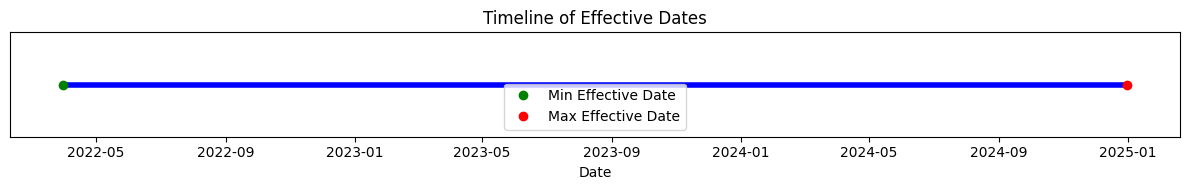

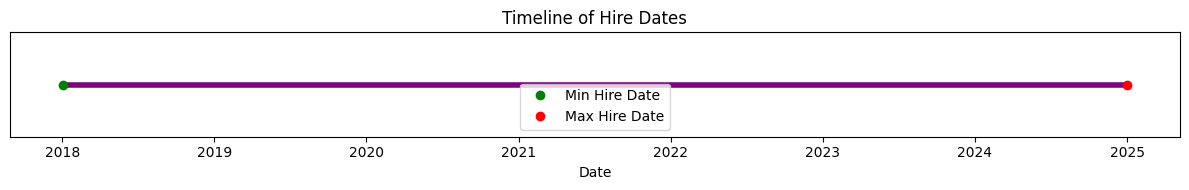

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

# Transforming date columns in datetime format
df['effective_date'] = pd.to_datetime(df['effective_date'], errors='coerce')
df['hire_date'] = pd.to_datetime(df['hire_date'], errors='coerce')

# Extracting min and max dates
effective_min = df['effective_date'].min()
effective_max = df['effective_date'].max()
hire_min = df['hire_date'].min()
hire_max = df['hire_date'].max()

# Timeline plot for effective_date

plt.figure(figsize=(12, 2))
plt.hlines(y=1, xmin=effective_min, xmax=effective_max, colors='blue', linewidth=4)
plt.plot(effective_min, 1, 'o', color='green', label='Min Effective Date')
plt.plot(effective_max, 1, 'o', color='red', label='Max Effective Date')
plt.title("Timeline of Effective Dates")
plt.xlabel("Date")
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()

# Similarly, a timeline plot for hire_date

plt.figure(figsize=(12, 2))
plt.hlines(y=1, xmin=hire_min, xmax=hire_max, colors='purple', linewidth=4)
plt.plot(hire_min, 1, 'o', color='green', label='Min Hire Date')
plt.plot(hire_max, 1, 'o', color='red', label='Max Hire Date')
plt.title("Timeline of Hire Dates")
plt.xlabel("Date")
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Converting key categorical variables to 'category' dtype
categorical_cols = ['job_function', 'location', 'employee_status', 'pay_rate_type','role_volume_type']
for col in categorical_cols:
    df[col] = df[col].astype('category')

In [ ]:
#Looking if there is any missing values in the data and the datatype - No null values, 2 datetime variables, rest are all categorical except for id
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69000 entries, 0 to 68999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   effective_date    69000 non-null  datetime64[ns]
 1   employee_id       69000 non-null  int64         
 2   job_function      69000 non-null  category      
 3   location          69000 non-null  category      
 4   job_level         69000 non-null  object        
 5   employee_status   69000 non-null  category      
 6   hire_date         69000 non-null  datetime64[ns]
 7   pay_rate_type     69000 non-null  category      
 8   role_volume_type  69000 non-null  category      
dtypes: category(5), datetime64[ns](2), int64(1), object(1)
memory usage: 2.4+ MB


# Feature Engineering

In [ ]:
df['tenure_days'] = (df['effective_date'] - df['hire_date']).dt.days

# Binary variable for Turnover (1 if Terminated, 0 if Active)
df['turnover_flag'] = np.where(df['employee_status'].str.lower() == 'terminated', 1, 0)


# Checked for any re-hires but there weren't any

# Flag for Promotion: We need a numeric representation of job_level for easy comparison (example: L2 -> 2)
def parse_level_to_int(x):
    return int(x.replace('L',''))

In [ ]:
df['job_level_num'] = df['job_level'].apply(parse_level_to_int)

df['previous_level_num'] = df.groupby('employee_id')['job_level_num'].shift(1)

df['promotion_flag'] = np.where(df['job_level_num'] > df['previous_level_num'], 1, 0)

df['promotion_flag'] = df['promotion_flag'].fillna(0)

df['tenure_squared'] = df['tenure_days']**2

df['job_level_sq'] = df['job_level_num'] ** 2

In [ ]:
# Pay Rate Type Change Flag
df['previous_pay_rate_type'] = df.groupby('employee_id')['pay_rate_type'].shift(1)
df['pay_rate_type_change_flag'] = np.where(df['pay_rate_type'] != df['previous_pay_rate_type'], 1, 0)
df['pay_rate_type_change_flag'] = df['pay_rate_type_change_flag'].fillna(0)

# Frequency of Promotions per Employee
promotion_counts = df.groupby('employee_id')['promotion_flag'].sum()

In [ ]:
# Creating a promotion_date column when a promotion is detected (if promotion_flag == 1, we will mark that quarter as the promotion date)
df['promotion_date'] = np.where(df['promotion_flag'] == 1, df['effective_date'], pd.NaT)

# Forward-fill the last promotion date for each employee
df['last_promotion_date'] = df.groupby('employee_id')['promotion_date'].ffill()

# We are computing days since last promotion.
# If never promoted, filling the with tenure_days as a proxy
df['days_since_last_promotion'] = (df['effective_date'].astype('datetime64[ns]') - df['last_promotion_date'].astype('datetime64[ns]')).dt.days
df['days_since_last_promotion'] = df['days_since_last_promotion'].fillna(df['tenure_days'])

# Descriptive Analysis

Tenure days are lesser for strategy and operations, we can deep dive and see that these are mostly hourly at Level 2 employees and some salaried employees as well at Level 3

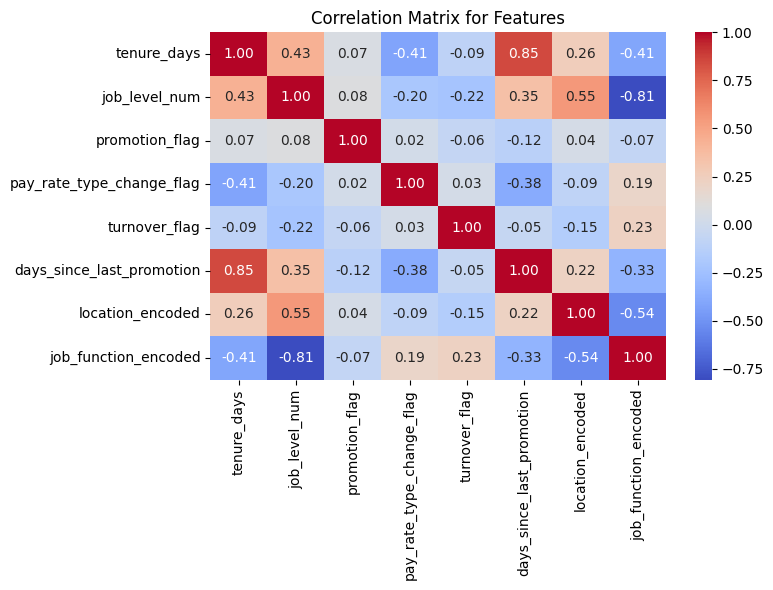

In [ ]:
# Cross-tabulation: Turnover (termination) by pay_rate_type
ct_pay = pd.crosstab(df['pay_rate_type'], df['turnover_flag'])

# Cross-tabulation: Turnover by role_volume_type - very similar to pay_rate_type
ct_role = pd.crosstab(df['role_volume_type'], df['turnover_flag'])

# Convert 'location' and 'job_function' to categorical
df['location'] = pd.Categorical(df['location'])
df['job_function'] = pd.Categorical(df['job_function'])

#  Create encoded columns
df['location_encoded'] = df['location'].cat.codes + 1
df['job_function_encoded'] = df['job_function'].cat.codes + 1

# Correlation Matrix: for numeric features
numeric_features = ['tenure_days', 'job_level_num', 'promotion_flag',
                    'pay_rate_type_change_flag',
                   'turnover_flag', 'days_since_last_promotion',
                   'location_encoded', 'job_function_encoded']
corr_matrix = df[numeric_features].corr()

# Visualizing correlation matrix using a heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix for Features")
plt.tight_layout()
plt.show()


Tenure and job level show a moderate positive correlation (0.43), while turnover is negatively correlated with tenure (-0.28). Overall, no pairwise correlations are extreme, suggesting minimal multicollinearity issues.

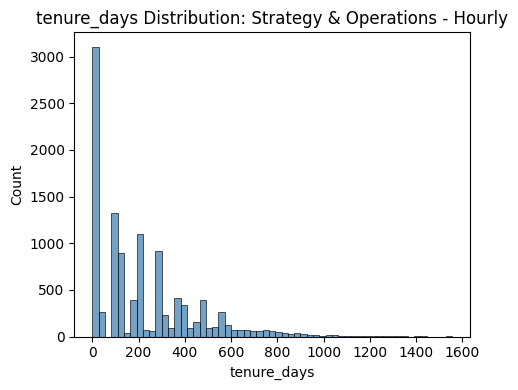

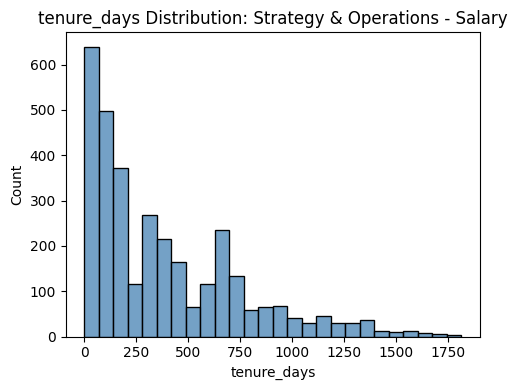

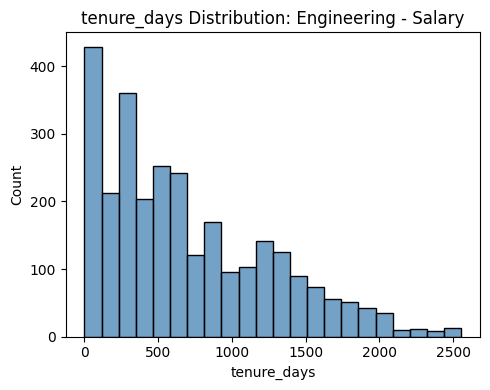

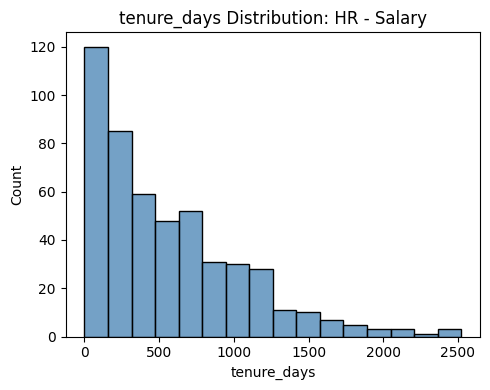

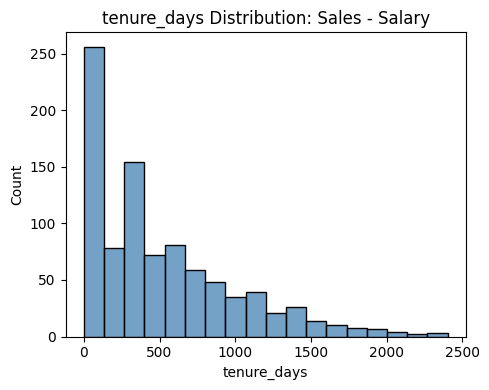

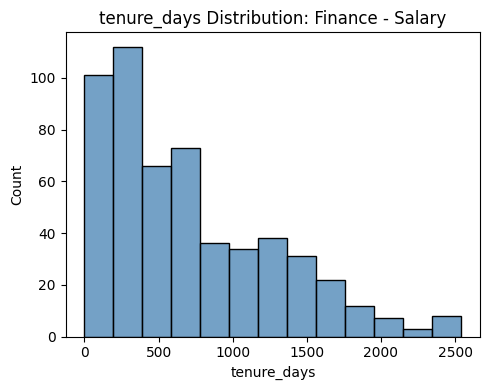

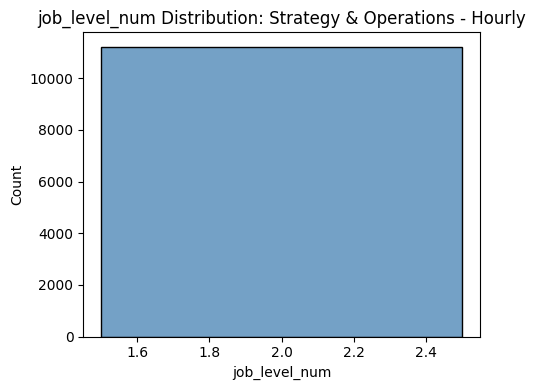

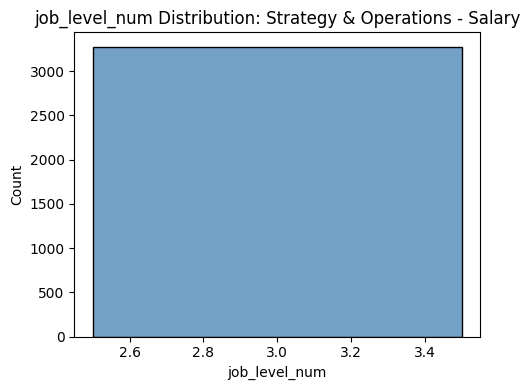

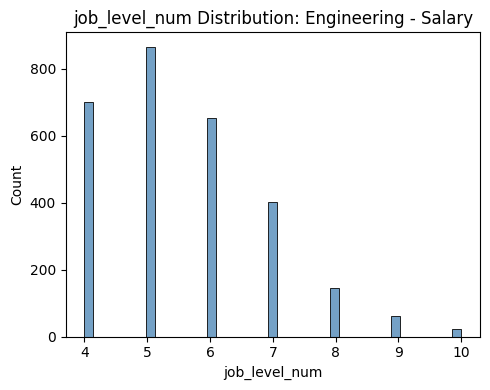

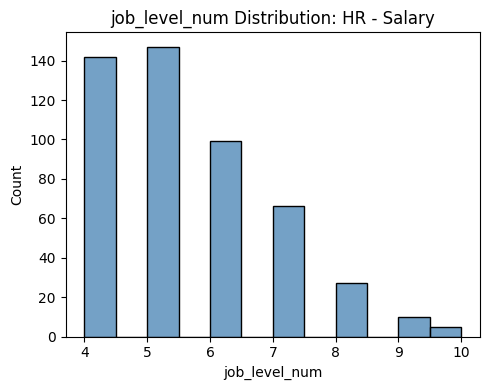

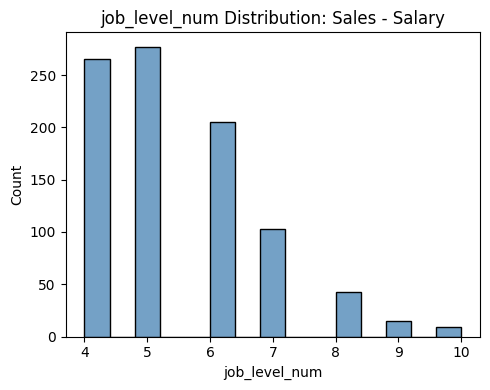

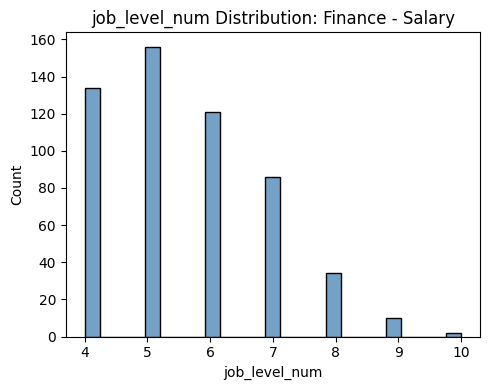

In [ ]:
df_sorted = df.sort_values(["employee_id", "effective_date"])
df_last = df_sorted.groupby("employee_id").last().reset_index()

num_vars = ['tenure_days', 'job_level_num']

# Getting the unique categories for job_function and pay_rate_type
job_functions = df_last['job_function'].unique()
pay_rate_types = df_last['pay_rate_type'].unique()

for var in num_vars:
    for job in job_functions:
        for pay in pay_rate_types:
            subset = df_last[(df_last['job_function'] == job) & (df_last['pay_rate_type'] == pay)]
            if subset.empty:
                continue
            plt.figure(figsize=(5,4))
            sns.histplot(data=subset, x=var, color='steelblue')
            plt.title(f"{var} Distribution: {job} - {pay}")
            plt.xlabel(var)
            plt.ylabel("Count")
            plt.tight_layout()
            plt.show()


Strategy and Operations has the shortest tenures – dominated by hourly paid employees at L2 level (Also some at salary payment type at L3 level)

In [ ]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 8.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=409f0eb024af610bf55bd1e034c82f86968fe05d556ab3431f91bcebc6640006
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


Now let's look at Salary type as the starting division, we see how Salaried employees have higher average tenure days

=== ANOVA for Tenure Days by Pay Rate Type ===
F-statistic: 3570.20, p-value: 0.0000e+00


<ipython-input-13-a7eb837ec51e>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_last, x='pay_rate_type', y='tenure_days', palette='pastel')


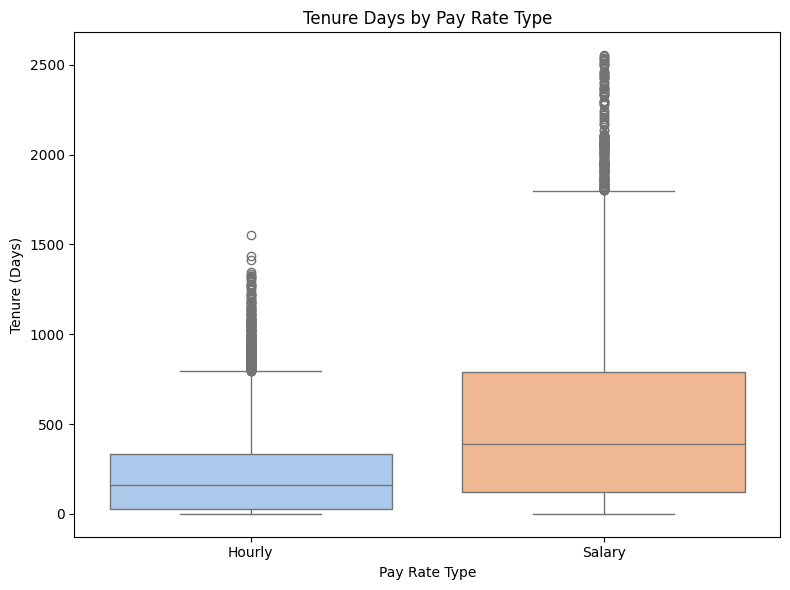

In [ ]:
import pandas as pd


df_sorted = df.sort_values(["employee_id", "effective_date"])

df_last = df_sorted.groupby("employee_id").last().reset_index()

# Now df_last has only one row per employee, containing the final status
# and final numeric measures (e.g., final tenure_days, job_function, location, etc.).

import numpy as np
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

groups_pay = []
for pay in df_last['pay_rate_type'].unique():
    group = df_last.loc[df_last['pay_rate_type'] == pay, 'tenure_days'].dropna()
    groups_pay.append(group)

f_stat, p_val = f_oneway(*groups_pay)
print("=== ANOVA for Tenure Days by Pay Rate Type ===")
print(f"F-statistic: {f_stat:.2f}, p-value: {p_val:.4e}")

# Visualize distribution with a boxplot
plt.figure(figsize=(8,6))
sns.boxplot(data=df_last, x='pay_rate_type', y='tenure_days', palette='pastel')
plt.title("Tenure Days by Pay Rate Type")
plt.xlabel("Pay Rate Type")
plt.ylabel("Tenure (Days)")
plt.tight_layout()
plt.show()




<ipython-input-23-15289c26b334>:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-23-15289c26b334>:40: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




  prev_pay_rate pay_rate_type  count
0        Hourly        Hourly      0
1        Hourly        Salary    402
2        Salary        Hourly      0
3        Salary        Salary      0

Turnover Rates by Hourly→Salary Transition:
   h2s_transition    sum  count  turnover_rate
0               0  13940  18895       0.737761
1               1    266    402       0.661692


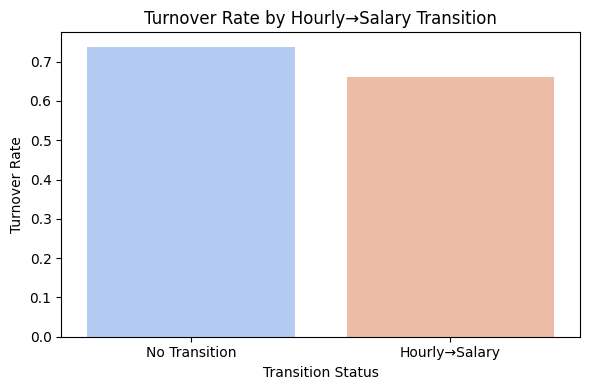

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sorting by employee and time
df_sorted = df.sort_values(['employee_id', 'effective_date']).copy()

# Computing lagged pay_rate_type for each employee
df_sorted['prev_pay_rate'] = df_sorted.groupby('employee_id')['pay_rate_type'].shift(1)

# Filtering rows where a pay_rate transition occurred
pay_transitions = df_sorted[(df_sorted['prev_pay_rate'].notnull()) &
                            (df_sorted['pay_rate_type'] != df_sorted['prev_pay_rate'])].copy()

# Focusing on transitions from Hourly to Salary
transition_h2s = pay_transitions[(pay_transitions['prev_pay_rate'] == 'Hourly') &
                                 (pay_transitions['pay_rate_type'] == 'Salary')]

print(transition_h2s.groupby(['prev_pay_rate', 'pay_rate_type']).size().reset_index(name='count'))


# This creates a cross-sectional snapshot for each employee.
df_sorted = df.sort_values(["employee_id", "effective_date"])
df_last = df_sorted.groupby("employee_id").last().reset_index()

# Creating a flag: 1 if an employee had a transition from Hourly to Salary, 0 otherwise.
employees_h2s = transition_h2s['employee_id'].unique()
df_last['h2s_transition'] = df_last['employee_id'].isin(employees_h2s).astype(int)

# Turnover_flag should be 1 for terminated, 0 for active.
# Computing the turnover rate for those with and without Hourly->Salary transitions.
turnover_by_transition = df_last.groupby('h2s_transition')['turnover_flag'].agg(['sum', 'count']).reset_index()
turnover_by_transition['turnover_rate'] = turnover_by_transition['sum'] / turnover_by_transition['count']

print("\nTurnover Rates by Hourly→Salary Transition:")
print(turnover_by_transition)

plt.figure(figsize=(6,4))
sns.barplot(x='h2s_transition', y='turnover_rate', data=turnover_by_transition, palette="coolwarm")
plt.xticks([0, 1], ['No Transition', 'Hourly→Salary'])
plt.xlabel("Transition Status")
plt.ylabel("Turnover Rate")
plt.title("Turnover Rate by Hourly→Salary Transition")
plt.tight_layout()
plt.show()

Employees who transitioned from Hourly to Salary have a slightly lower turnover rate than those with no transition, suggesting that moving into a salaried role is associated with higher retention. For 402 employees the pay rate changed from Hourly to Salary

# Hypothesis Testing and Modelling


For pay_rate_type = Hourly, there is not enough variation in job_function to perform post-hoc analysis.

=== Post-hoc Tukey HSD for Job Function within Pay Rate Type: Salary ===
             Multiple Comparison of Means - Tukey HSD, FWER=0.05             
   group1           group2         meandiff p-adj    lower     upper   reject
-----------------------------------------------------------------------------
Engineering               Finance    3.2359 0.9999   -57.965   64.4369  False
Engineering                    HR -144.2791    0.0 -207.8688  -80.6893   True
Engineering                 Sales -184.5314    0.0 -234.1547 -134.9081   True
Engineering Strategy & Operations -322.3201    0.0 -355.8069 -288.8334   True
    Finance                    HR  -147.515    0.0 -228.6939   -66.336   True
    Finance                 Sales -187.7673    0.0 -258.5404 -116.9942   True
    Finance Strategy & Operations  -325.556    0.0 -386.1177 -264.9943   True
         HR                 Sales  -40.25

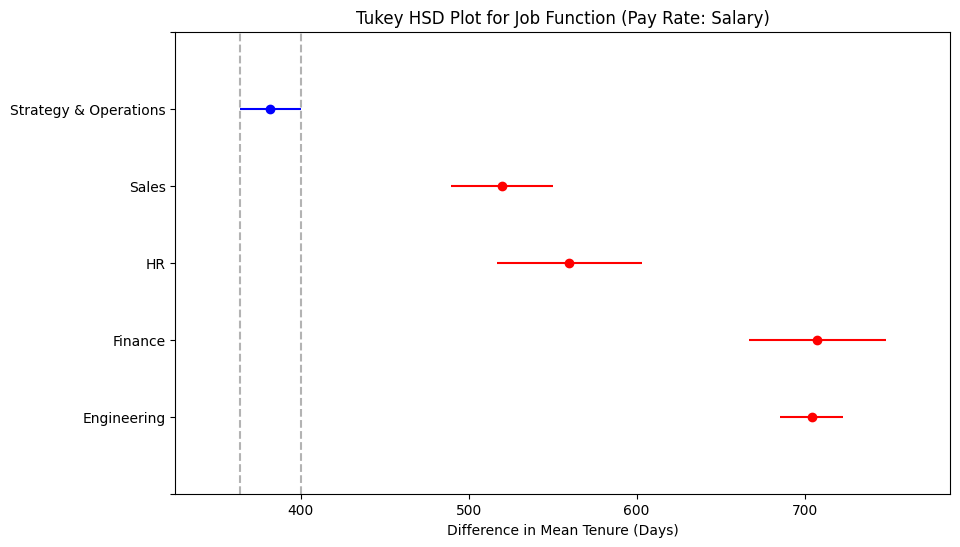

In [ ]:
#For each pay_rate_type, we want to see if average tenure differs by job_function to statistically test our Hypothesis
from statsmodels.stats.multicomp import pairwise_tukeyhsd # Importing the function

for pay in df_last['pay_rate_type'].unique():
    subset = df_last[df_last['pay_rate_type'] == pay].copy()
    # Ensuring job_function is categorical
    subset['job_function'] = subset['job_function'].astype('category')

    # Checking if there is enough data for post-hoc testing (at least 2 groups)
    if subset['job_function'].nunique() < 2:
        print(f"\nFor pay_rate_type = {pay}, there is not enough variation in job_function to perform post-hoc analysis.")
        continue

    tukey = pairwise_tukeyhsd(endog=subset['tenure_days'],
                              groups=subset['job_function'],
                              alpha=0.05)
    print(f"\n=== Post-hoc Tukey HSD for Job Function within Pay Rate Type: {pay} ===")
    print(tukey)


    tukey.plot_simultaneous(comparison_name=subset['job_function'].unique()[0], xlabel='Difference in Mean Tenure (Days)')
    plt.title(f"Tukey HSD Plot for Job Function (Pay Rate: {pay})")
    plt.show()

For salaried, Strategy & Operations has a notably lower mean tenure compared to Engineering or Finance (over 300 days difference). Sales and HR also show significantly lower tenure compared to Engineering or Finance, but the difference between HR and Sales themselves is not significant.



Unique locations: ['MoonMart 1, The Moon', 'Orlando, Florida', 'MoonMart 2, The Moon', 'New York City, New York', 'Seattle, Washington', 'San Francisco, California', 'Tempe, Arizona']
Categories (7, object): ['MoonMart 1, The Moon', 'MoonMart 2, The Moon', 'New York City, New York',
                         'Orlando, Florida', 'San Francisco, California', 'Seattle, Washington',
                         'Tempe, Arizona']

=== ANOVA for Tenure Days by Location ===
F-statistic: 726.40, p-value: 0.0000e+00
Significant differences among locations in average tenure. Performing Tukey HSD post-hoc analysis...

                      Multiple Comparison of Means - Tukey HSD, FWER=0.05                      
          group1                    group2           meandiff p-adj    lower     upper   reject
-----------------------------------------------------------------------------------------------
     MoonMart 1, The Moon      MoonMart 2, The Moon    8.3317 0.9453  -15.3399   32.0033  False
     M

<ipython-input-35-d97eb154917a>:42: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




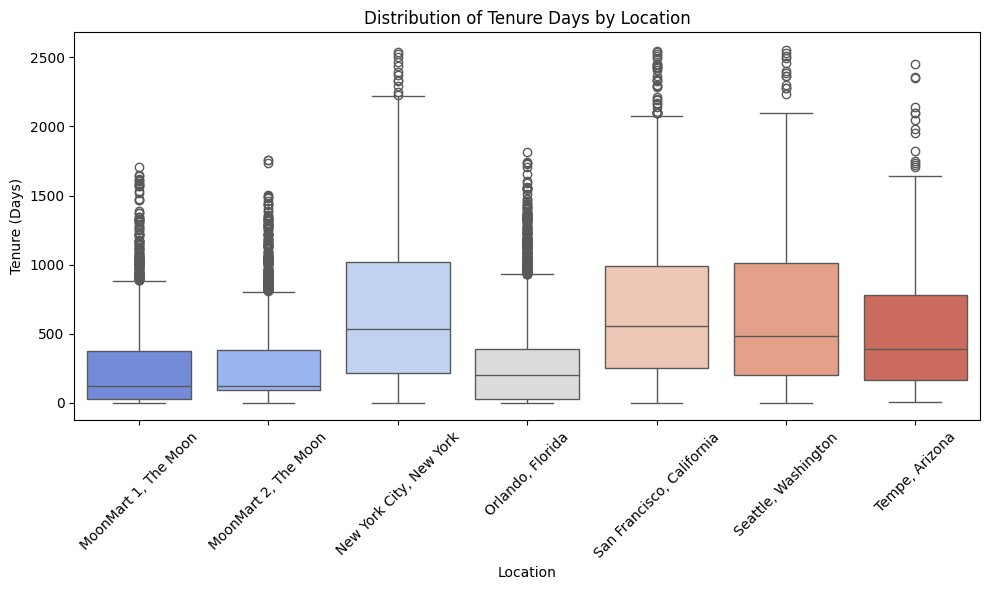

In [ ]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

unique_locations = df_last['location'].dropna().unique()
print("Unique locations:", unique_locations)

# Prepare groups: Extract 'tenure_days' for each location
groups = []
for loc in unique_locations:
    group_data = df_last.loc[df_last['location'] == loc, 'tenure_days'].dropna()
    groups.append(group_data)

# Performing one-way ANOVA
f_stat, p_val = f_oneway(*groups)
print("\n=== ANOVA for Tenure Days by Location ===")
print(f"F-statistic: {f_stat:.2f}, p-value: {p_val:.4e}")

if p_val < 0.05:
    print("Significant differences among locations in average tenure. Performing Tukey HSD post-hoc analysis...\n")
    # Flatten data for Tukey's test
    all_data = []
    all_labels = []
    for loc in unique_locations:
        subset = df_last.loc[df_last['location'] == loc, 'tenure_days'].dropna()
        all_data.extend(subset.values)
        all_labels.extend([loc] * len(subset))

    tukey = pairwise_tukeyhsd(endog=np.array(all_data),
                              groups=np.array(all_labels),
                              alpha=0.05)
    print(tukey)
else:
    print("No significant differences among locations in average tenure.")


# Boxplot by Location

plt.figure(figsize=(10,6))
sns.boxplot(data=df_last, x='location', y='tenure_days', palette='coolwarm')
plt.title("Distribution of Tenure Days by Location")
plt.xlabel("Location")
plt.ylabel("Tenure (Days)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

=== ANOVA and Post-Hoc for Job Function within Each City ===

City: New York City, New York -- ANOVA for Tenure Days by Job Function
F-statistic: 12.64, p-value: 3.7058e-08
Significant differences among job functions. Performing Tukey’s HSD post-hoc test...

      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1    group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------------
Engineering Finance  -60.3511 0.6659 -196.7384   76.0362  False
Engineering      HR -221.7395 0.0002 -358.1268  -85.3522   True
Engineering   Sales -203.6231    0.0 -306.1406 -101.1056   True
    Finance      HR -161.3884 0.1013 -342.8267   20.0499  False
    Finance   Sales  -143.272 0.0899 -300.8417   14.2977  False
         HR   Sales   18.1164  0.991 -139.4533  175.6861  False
---------------------------------------------------------------


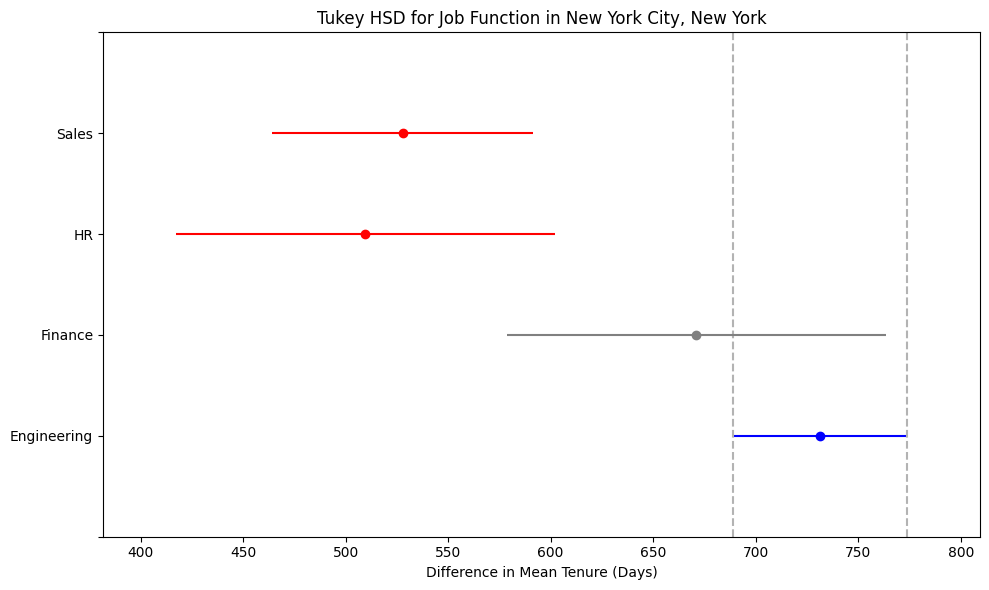


City: San Francisco, California -- ANOVA for Tenure Days by Job Function
F-statistic: 6.21, p-value: 3.3977e-04
Significant differences among job functions. Performing Tukey’s HSD post-hoc test...

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1    group2  meandiff p-adj    lower    upper   reject
--------------------------------------------------------------
Engineering Finance   44.1217 0.5028  -37.2249 125.4682  False
Engineering      HR  -62.4287 0.6677   -203.83  78.9726  False
Engineering   Sales -144.6754 0.0025 -250.3867  -38.964   True
    Finance      HR -106.5504 0.2626 -256.8139  43.7131  False
    Finance   Sales -188.7971 0.0002 -306.0987 -71.4954   True
         HR   Sales  -82.2467 0.5733  -246.979  82.4857  False
--------------------------------------------------------------


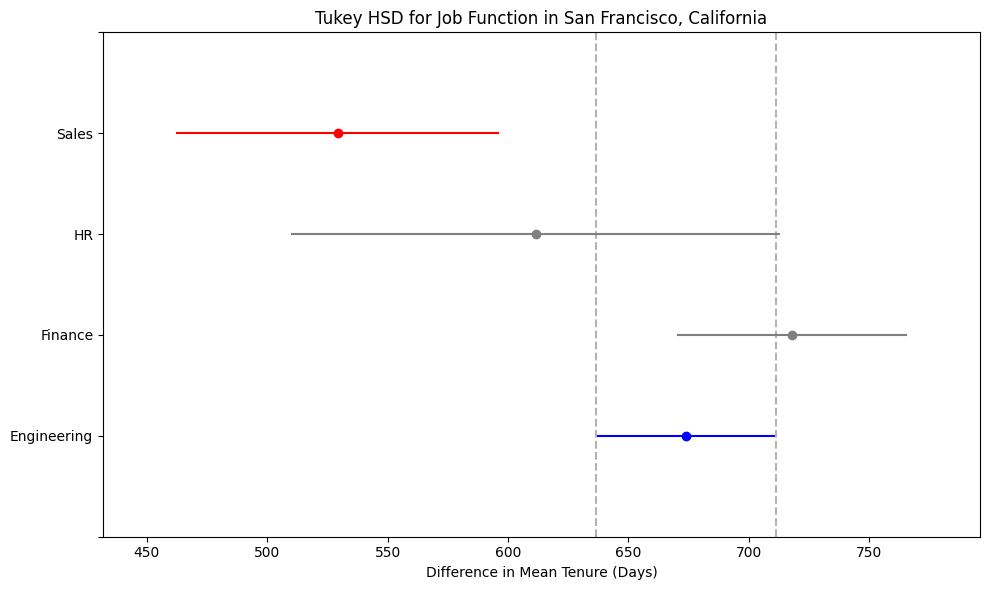


City: Seattle, Washington -- ANOVA for Tenure Days by Job Function
F-statistic: 16.75, p-value: 6.5185e-08
Significant differences among job functions. Performing Tukey’s HSD post-hoc test...

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1   group2  meandiff p-adj    lower    upper   reject
-------------------------------------------------------------
Engineering     HR -143.9403 0.0103 -260.0052 -27.8754   True
Engineering  Sales -211.7364    0.0 -303.5679 -119.905   True
         HR  Sales  -67.7962 0.4705 -203.5943   68.002  False
-------------------------------------------------------------


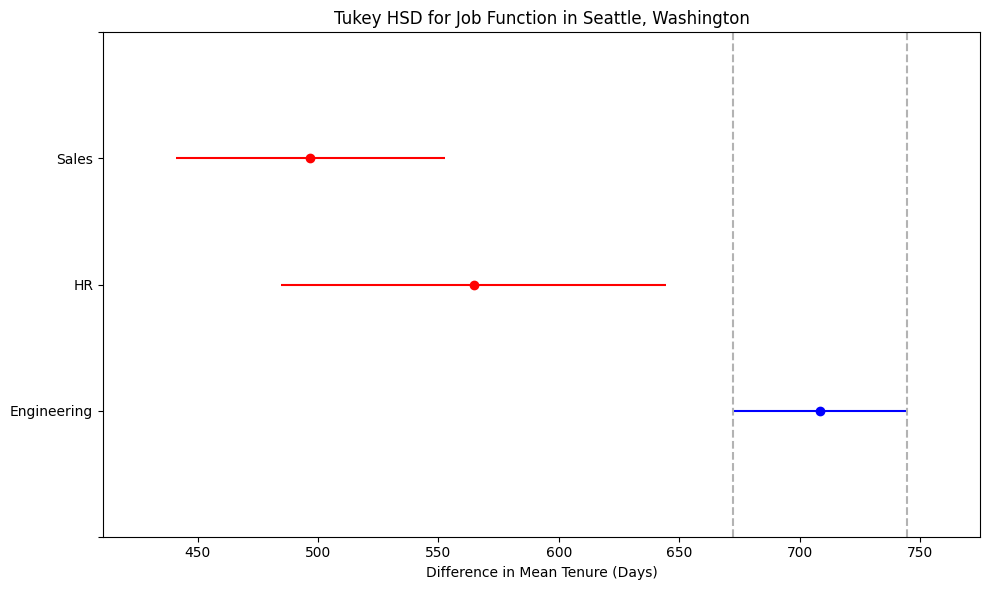


=== ANOVA and Post-Hoc for Job Level within Each City ===

City: New York City, New York -- ANOVA for Tenure Days by Job Level
F-statistic: 10.09, p-value: 6.0316e-11
Significant differences among job levels. Performing Tukey’s HSD post-hoc test...

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
    10      4 -156.334 0.9589 -628.6813 316.0132  False
    10      5  20.0026    1.0 -451.2152 491.2205  False
    10      6  -7.5862    1.0 -479.9334 464.7611  False
    10      7 198.7205 0.8852 -280.9485 678.3895  False
    10      8 153.7645 0.9723 -349.5278 657.0568  False
    10      9  116.727 0.9961 -435.5987 669.0527  False
     4      5 176.3367 0.0002   59.6974  292.976   True
     4      6 148.7479 0.0055   27.6266 269.8692   True
     4      7 355.0546    0.0  207.9464 502.1628   True
     4      8 310.0985 0.0003    98.293  521.904   True
     4      9 273.061

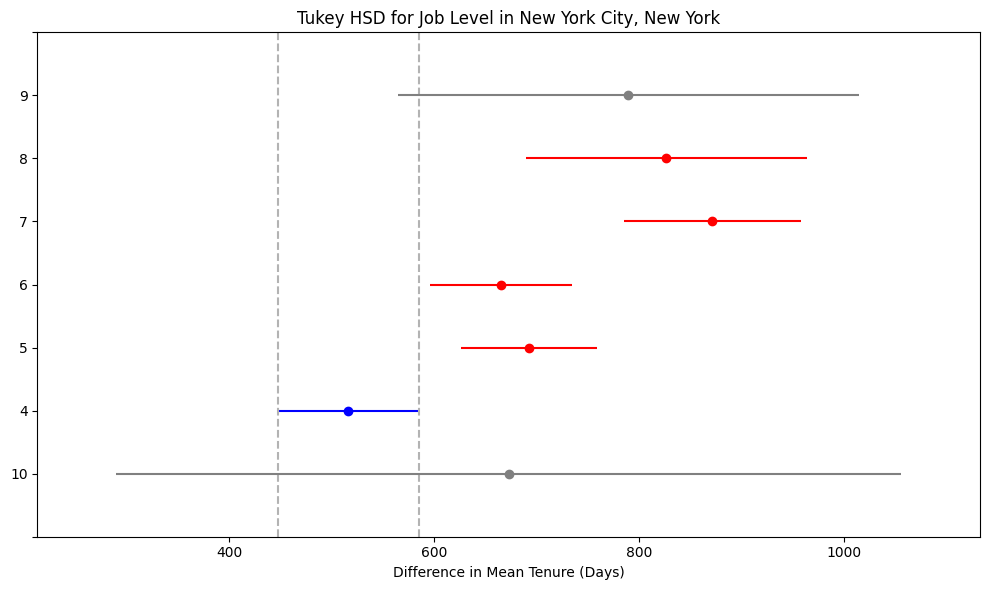


City: San Francisco, California -- ANOVA for Tenure Days by Job Level
F-statistic: 16.55, p-value: 1.2899e-18
Significant differences among job levels. Performing Tukey’s HSD post-hoc test...

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower    upper   reject
--------------------------------------------------------
    10      4   54.5821 0.9999 -422.9993 532.1636  False
    10      5  147.1599 0.9708 -329.4085 623.7282  False
    10      6  254.7219 0.7011 -223.9363 733.3801  False
    10      7    438.21 0.1041  -44.5782 920.9983  False
    10      8  368.8248 0.3141 -133.5549 871.2046  False
    10      9  227.8485 0.8806 -316.8635 772.5605  False
     4      5   92.5777 0.0952   -8.0937 193.2492  False
     4      6  200.1397    0.0   89.9989 310.2806   True
     4      7  383.6279    0.0  256.7347  510.521   True
     4      8  314.2427    0.0  126.0865 502.3989   True
     4      9  173.2663 0.5405  -109.096 455.6287  False
     5  

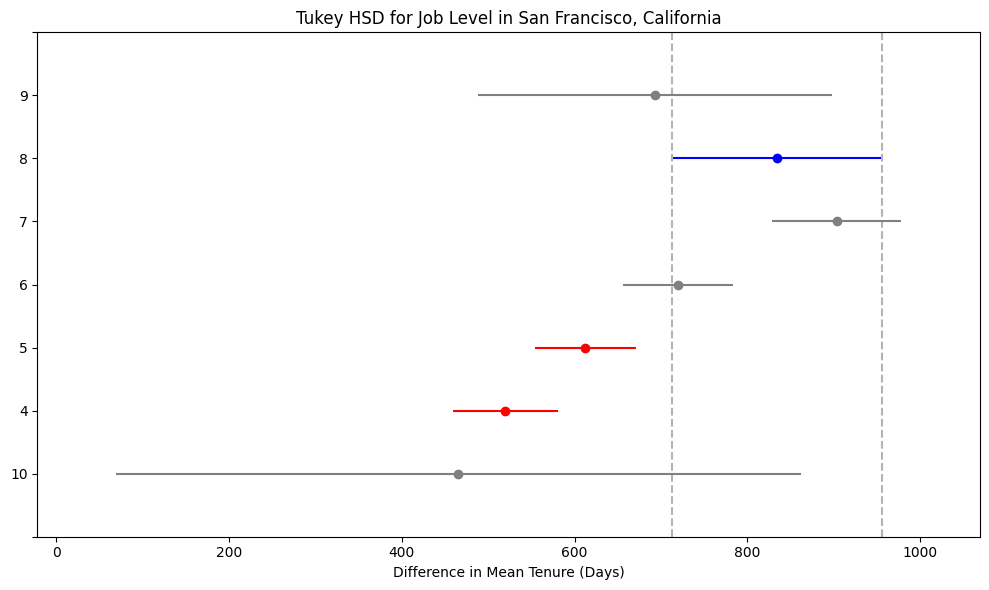


City: Seattle, Washington -- ANOVA for Tenure Days by Job Level
F-statistic: 10.37, p-value: 2.9176e-11
Significant differences among job levels. Performing Tukey’s HSD post-hoc test...

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
    10      4   6.8869    1.0 -464.1814 477.9552  False
    10      5 145.1011 0.9709 -325.1783 615.3806  False
    10      6 136.9985 0.9789 -336.2611  610.258  False
    10      7 337.8943 0.3578 -138.9939 814.7825  False
    10      8 312.9357 0.5085 -184.2653 810.1366  False
    10      9 379.6102 0.3808 -165.9946  925.215  False
     4      5 138.2142 0.0097   20.5346 255.8938   True
     4      6 130.1116 0.0467    1.0367 259.1864   True
     4      7 331.0074    0.0  189.2045 472.8102   True
     4      8 306.0487 0.0001  106.3127 505.7848   True
     4      9 372.7233 0.0049   72.1068 673.3398   True
     5      6  -8.1027    1.

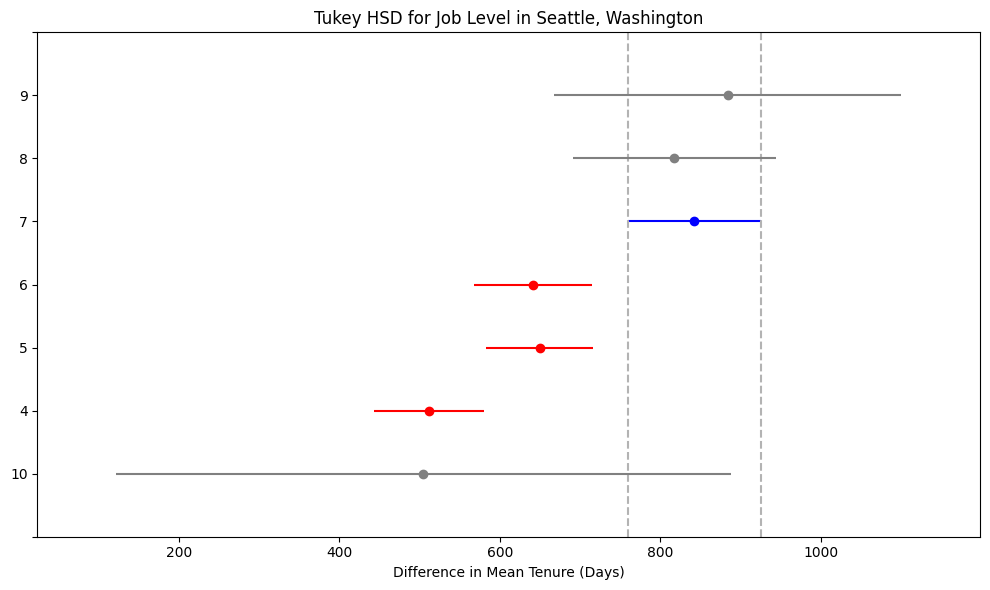

In [ ]:
# cities where we see high turnover in our exploratory analysis.
cities = ["New York City, New York", "San Francisco, California", "Seattle, Washington"]
df_cities = df_last[df_last['location'].isin(cities)].copy()

print("=== ANOVA and Post-Hoc for Job Function within Each City ===")
for city in cities:
    subset = df_cities[df_cities['location'] == city].copy()

    # Ensuring job_function is treated as a categorical variable
    subset['job_function'] = subset['job_function'].astype('category')

    # Checking that there is enough variation (at least 2 unique job functions)
    if subset['job_function'].nunique() < 2:
        print(f"\nCity {city}: Not enough variation in job_function to perform post-hoc analysis.")
        continue

    # Extracting groups (tenure_days for each job_function)
    groups = [subset.loc[subset['job_function'] == grp, 'tenure_days'].dropna()
              for grp in subset['job_function'].unique()]

    # Perform one-way ANOVA
    f_stat, p_val = f_oneway(*groups)
    print(f"\nCity: {city} -- ANOVA for Tenure Days by Job Function")
    print(f"F-statistic: {f_stat:.2f}, p-value: {p_val:.4e}")

    if p_val < 0.05:
        print("Significant differences among job functions. Performing Tukey’s HSD post-hoc test...\n")
        # Prepare data for Tukey's test
        all_data = []
        all_labels = []
        for grp in subset['job_function'].unique():
            data_grp = subset.loc[subset['job_function'] == grp, 'tenure_days'].dropna()
            all_data.extend(data_grp.values)
            all_labels.extend([grp]*len(data_grp))

        tukey = pairwise_tukeyhsd(endog=np.array(all_data),
                                  groups=np.array(all_labels),
                                  alpha=0.05)
        print(tukey)
        # Plotting the Tukey HSD results
        tukey.plot_simultaneous(comparison_name=str(subset['job_function'].unique()[0]),
                                xlabel="Difference in Mean Tenure (Days)")
        plt.title(f"Tukey HSD for Job Function in {city}")
        plt.tight_layout()
        plt.show()
    else:
        print("No significant differences among job functions in", city)

print("\n=== ANOVA and Post-Hoc for Job Level within Each City ===")
# Converting job_level_num to a categorical variable
df_cities['job_level_cat'] = df_cities['job_level_num'].astype(str)

for city in cities:
    subset = df_cities[df_cities['location'] == city].copy()

    # Checking that there is enough variation in job_level_cat
    if subset['job_level_cat'].nunique() < 2:
        print(f"\nCity {city}: Not enough variation in job_level to perform post-hoc analysis.")
        continue

    groups = [subset.loc[subset['job_level_cat'] == lvl, 'tenure_days'].dropna()
              for lvl in subset['job_level_cat'].unique()]

    f_stat, p_val = f_oneway(*groups)
    print(f"\nCity: {city} -- ANOVA for Tenure Days by Job Level")
    print(f"F-statistic: {f_stat:.2f}, p-value: {p_val:.4e}")

    if p_val < 0.05:
        print("Significant differences among job levels. Performing Tukey’s HSD post-hoc test...\n")
        all_data = []
        all_labels = []
        for lvl in subset['job_level_cat'].unique():
            data_lvl = subset.loc[subset['job_level_cat'] == lvl, 'tenure_days'].dropna()
            all_data.extend(data_lvl.values)
            all_labels.extend([lvl] * len(data_lvl))

        tukey = pairwise_tukeyhsd(endog=np.array(all_data),
                                  groups=np.array(all_labels),
                                  alpha=0.05)
        print(tukey)
        tukey.plot_simultaneous(comparison_name=str(subset['job_level_cat'].unique()[0]),
                                xlabel="Difference in Mean Tenure (Days)")
        plt.title(f"Tukey HSD for Job Level in {city}")
        plt.tight_layout()
        plt.show()
    else:
        print("No significant differences among job levels in", city)

Chi-Square Tests

In [ ]:
# Testing if turnover rate differs significantly between High vs Low volume roles.
contingency_role = pd.crosstab(df['role_volume_type'], df['turnover_flag'])
print("\nContingency Table for role_volume_type vs. turnover_flag:\n", contingency_role)

# Chi-square test for independence
chi2, p_value, dof, expected = chi2_contingency(contingency_role)
print("Chi-square Test: chi2 = {:.2f}, p-value = {:.4f}, dof = {}".format(chi2, p_value, dof))
if p_value < 0.05:
    print("Significant difference in turnover rates between high and low volume roles.")
else:
    print("No significant difference detected between high and low volume roles.")



Contingency Table for role_volume_type vs. turnover_flag:
 turnover_flag         0     1
role_volume_type             
High              20634  9282
Low               34160  4924
Chi-square Test: chi2 = 3518.69, p-value = 0.0000, dof = 1
Significant difference in turnover rates between high and low volume roles.


In [ ]:
# Testing if turnover rate differs significantly between job_level_num.
contingency_role = pd.crosstab(df['job_level_num'], df['turnover_flag'])
print("\nContingency Table for job_level_num vs. turnover_flag:\n", contingency_role)

# Chi-square test for independence
chi2, p_value, dof, expected = chi2_contingency(contingency_role)
print("Chi-square Test: chi2 = {:.2f}, p-value = {:.4f}, dof = {}".format(chi2, p_value, dof))
if p_value < 0.05:
    print("Significant difference in turnover rates between job levels")
else:
    print("No significant difference detected between job levels")


Contingency Table for job_level_num vs. turnover_flag:
 turnover_flag      0     1
job_level_num             
2              20634  9282
3               9774  2310
4               5701   760
5               7035   827
6               5332   586
7               3890   272
8               1637   105
9                619    39
10               172    25
Chi-square Test: chi2 = 4041.17, p-value = 0.0000, dof = 8
Significant difference in turnover rates between job levels


In [ ]:
# Testing if turnover rate differs significantly between job_func.
contingency_role = pd.crosstab(df['job_function'], df['turnover_flag'])
print("\nContingency Table for job_function vs. turnover_flag:\n", contingency_role)

# Chi-square test for independence
chi2, p_value, dof, expected = chi2_contingency(contingency_role)
print("Chi-square Test: chi2 = {:.2f}, p-value = {:.4f}, dof = {}".format(chi2, p_value, dof))
if p_value < 0.05:
    print("Significant difference in turnover rates between job levels")
else:
    print("No significant difference detected between job levels")


Contingency Table for job_function vs. turnover_flag:
 turnover_flag              0      1
job_function                       
Engineering            16337   1297
Finance                 3172    238
HR                      2046    338
Sales                   2831    741
Strategy & Operations  30408  11592
Chi-square Test: chi2 = 3597.95, p-value = 0.0000, dof = 4
Significant difference in turnover rates between job levels


In [ ]:
# Testing if turnover rate differs significantly between location
contingency_role = pd.crosstab(df['location'], df['turnover_flag'])
print("\nContingency Table for loc vs. turnover_flag:\n", contingency_role)

# Chi-square test for independence
chi2, p_value, dof, expected = chi2_contingency(contingency_role)
print("Chi-square Test: chi2 = {:.2f}, p-value = {:.4f}, dof = {}".format(chi2, p_value, dof))
if p_value < 0.05:
    print("Significant difference in turnover rates between loc")
else:
    print("No significant difference detected between loc")


Contingency Table for loc vs. turnover_flag:
 turnover_flag                  0     1
location                              
MoonMart 1, The Moon        7737  3334
MoonMart 2, The Moon        8137  3315
New York City, New York     7450   723
Orlando, Florida           14534  4943
San Francisco, California   8900   918
Seattle, Washington         6838   710
Tempe, Arizona              1198   263
Chi-square Test: chi2 = 3408.13, p-value = 0.0000, dof = 6
Significant difference in turnover rates between loc



Turnover by Promotion Flag:
 turnover_flag       0      1
promotion_flag              
0               53703  14206
1                1091      0

Proportion of turnover by Promotion Flag:
 turnover_flag          0         1
promotion_flag                    
0               0.790808  0.209192
1               1.000000  0.000000


<Figure size 800x400 with 0 Axes>

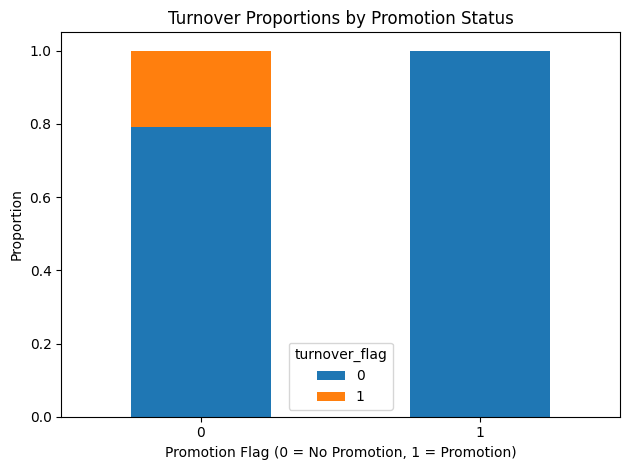

In [ ]:
#  Turnover Rate by Promotion Status
turnover_by_promotion = pd.crosstab(df['promotion_flag'], df['turnover_flag'])
print("\nTurnover by Promotion Flag:\n", turnover_by_promotion)
# Calculating proportions
prop_promotion = turnover_by_promotion.div(turnover_by_promotion.sum(axis=1), axis=0)
print("\nProportion of turnover by Promotion Flag:\n", prop_promotion)

# Visualizing these proportions using bar plots.
plt.figure(figsize=(8,4))
prop_promotion.plot(kind='bar', stacked=True)
plt.title("Turnover Proportions by Promotion Status")
plt.xlabel("Promotion Flag (0 = No Promotion, 1 = Promotion)")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



This shows that Employees who received a promotion have a lower proportion of terminations compared to those who did not receive a promotion, suggesting promotions may help retain employees.

# Survival Analysis and Cox Model

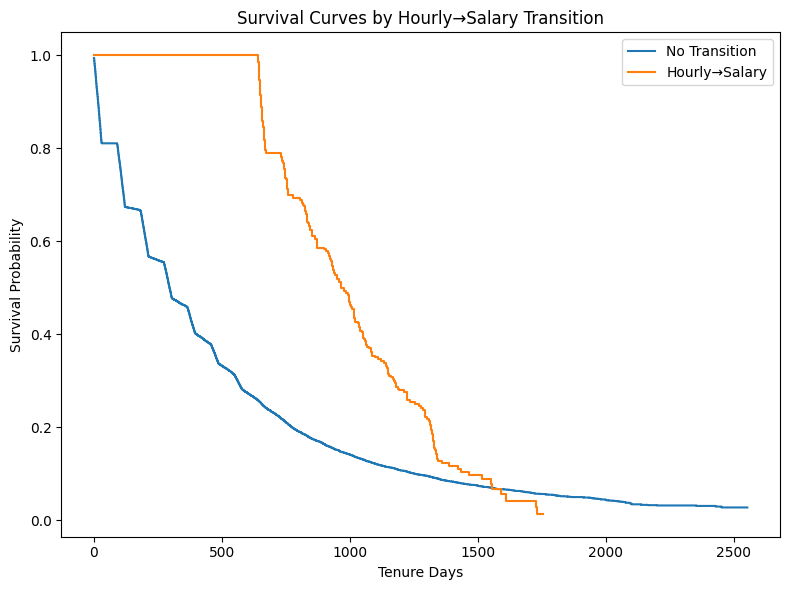


=== Cox Model Including Hourly→Salary Transition ===


<lifelines.CoxPHFitter: fitted with 19297 total observations, 5091 right-censored observations>
             duration col = 'tenure_days'
                event col = 'turnover_flag'
      baseline estimation = breslow
   number of observations = 19297
number of events observed = 14206
   partial log-likelihood = -126980.06
         time fit was run = 2025-03-16 16:33:46 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
h2s_transition -0.99      0.37      0.06           -1.11           -0.87                0.33                0.42

                cmp to      z      p  -log2(p)
covariate                                     
h2s_transition    0.00 -15.99 <0.005    188.72
---
Concordance = 0.52
Partial AIC = 253962.12
log-likelihood ratio test = 357.15 on 1 df
-log2(p) of ll-ratio test = 262.20

In [ ]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

if 'h2s_transition' not in df_last.columns:

    df_sorted_for_h2s = df.sort_values(['employee_id', 'effective_date']).copy()
    df_sorted_for_h2s['prev_pay_rate'] = df_sorted_for_h2s.groupby('employee_id')['pay_rate_type'].shift(1)

    pay_transitions = df_sorted_for_h2s[
        (df_sorted_for_h2s['prev_pay_rate'].notnull()) &
        (df_sorted_for_h2s['pay_rate_type'] != df_sorted_for_h2s['prev_pay_rate'])
    ].copy()

    transition_h2s = pay_transitions[
        (pay_transitions['prev_pay_rate'] == 'Hourly') &
        (pay_transitions['pay_rate_type'] == 'Salary')
    ]

    employees_h2s = transition_h2s['employee_id'].unique()
    df_last['h2s_transition'] = df_last['employee_id'].isin(employees_h2s).astype(int)



plt.figure(figsize=(8,6))
for label, grouped_df in df_last.groupby('h2s_transition'):
    label_name = "Hourly→Salary" if label==1 else "No Transition"
    kmf.fit(grouped_df['tenure_days'], event_observed=grouped_df['turnover_flag'], label=label_name)
    kmf.plot(ci_show=False)

plt.title("Survival Curves by Hourly→Salary Transition")
plt.xlabel("Tenure Days")
plt.ylabel("Survival Probability")
plt.tight_layout()
plt.show()

# fitting a Cox model to quantify the hazard ratio of having the transition.
from lifelines import CoxPHFitter
cph = CoxPHFitter()
# Ensure relevant columns are present (and drop any missing data)
df_cox = df_last.dropna(subset=['tenure_days', 'turnover_flag', 'h2s_transition']).copy()
cph.fit(df_cox[['tenure_days', 'turnover_flag', 'h2s_transition']],
        duration_col='tenure_days', event_col='turnover_flag')
print("\n=== Cox Model Including Hourly→Salary Transition ===")
cph.print_summary()



Promotion rates by previous job level:
 previous_level_num
2.0    402
4.0    256
5.0    251
6.0    182
dtype: int64

Distribution (sample) of days to first promotion:
    employee_id  days_to_first_promotion
0           12                      428
1           25                      498
2           72                      826
3          101                     1063
4          159                      717


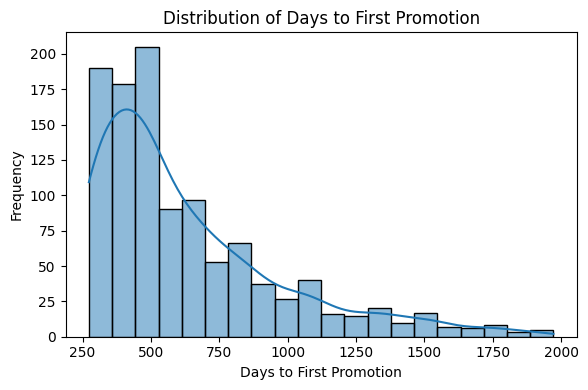

In [ ]:
# Promotion Rates by Job Level: Count number of promotions from each level to a higher level.
# We assume that a promotion occurs when current job_level_num > previous_level_num.
promotions = df[df['promotion_flag'] == 1]
promotion_rates_by_level = promotions.groupby('previous_level_num').size()
print("\nPromotion rates by previous job level:\n", promotion_rates_by_level)

# Distribution of Time to First Promotion:
# For each employee, find the first quarter where promotion_flag == 1
first_promotion = df[df['promotion_flag'] == 1].groupby('employee_id')['effective_date'].min().reset_index()
# Merge with hire_date to compute time (in days) to first promotion
first_promotion = first_promotion.merge(df[['employee_id','hire_date']].drop_duplicates(), on='employee_id', how='left')
first_promotion['days_to_first_promotion'] = (first_promotion['effective_date'] - first_promotion['hire_date']).dt.days
print("\nDistribution (sample) of days to first promotion:\n", first_promotion[['employee_id', 'days_to_first_promotion']].head())

plt.figure(figsize=(6,4))
sns.histplot(first_promotion['days_to_first_promotion'].dropna(), bins=20, kde=True)
plt.title("Distribution of Days to First Promotion")
plt.xlabel("Days to First Promotion")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import f_oneway

# Getting tenure_days for each role category
tenure_entry = df[df['role_category'] == 'Entry']['tenure_days']
tenure_mid   = df[df['role_category'] == 'Mid']['tenure_days']
tenure_senior= df[df['role_category'] == 'Senior']['tenure_days']

# Performing ANOVA
f_stat, p_value = f_oneway(tenure_entry, tenure_mid, tenure_senior)
print("\nANOVA Test for Tenure Days Across Role Categories:")
print(f"F-statistic: {f_stat:.2f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Significant differences in average tenure among role categories (reject null hypothesis).")
else:
    print("No significant differences in average tenure among role categories (fail to reject null hypothesis).")

#Post-Hoc Analysis***


ANOVA Test for Tenure Days Across Role Categories:
F-statistic: 6488.16
P-value: 0.0000
Significant differences in average tenure among role categories (reject null hypothesis).


In [ ]:
# For survival analysis
from lifelines import KaplanMeierFitter, CoxPHFitter

# For ARIMA forecasting
from statsmodels.tsa.arima.model import ARIMA


# Sort data and get the last record per employee
df_surv = df.sort_values(by=['employee_id', 'effective_date']).groupby('employee_id').last().reset_index()
df_surv['duration'] = (df_surv['effective_date'] - df_surv['hire_date']).dt.days
df_surv['event'] = df_surv['turnover_flag']  # 1 if terminated, 0 if active

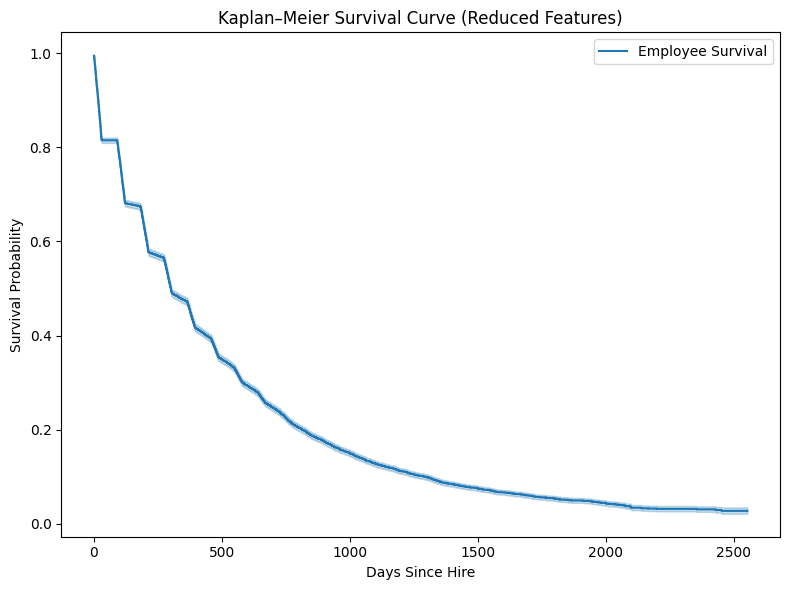

In [ ]:
# A. Kaplan–Meier
# Collapsing the panel data to last record per employee to define final status
df_surv = df.sort_values(by=['employee_id','effective_date']).groupby('employee_id').last().reset_index()
df_surv['duration'] = (df_surv['effective_date'] - df_surv['hire_date']).dt.days
df_surv['event'] = df_surv['turnover_flag']  # 1 if terminated, 0 otherwise

kmf = KaplanMeierFitter()
kmf.fit(durations=df_surv['duration'], event_observed=df_surv['event'], label="Employee Survival")

plt.figure(figsize=(8,6))
kmf.plot()
plt.title("Kaplan–Meier Survival Curve (Reduced Features)")
plt.xlabel("Days Since Hire")
plt.ylabel("Survival Probability")
plt.tight_layout()
plt.show()


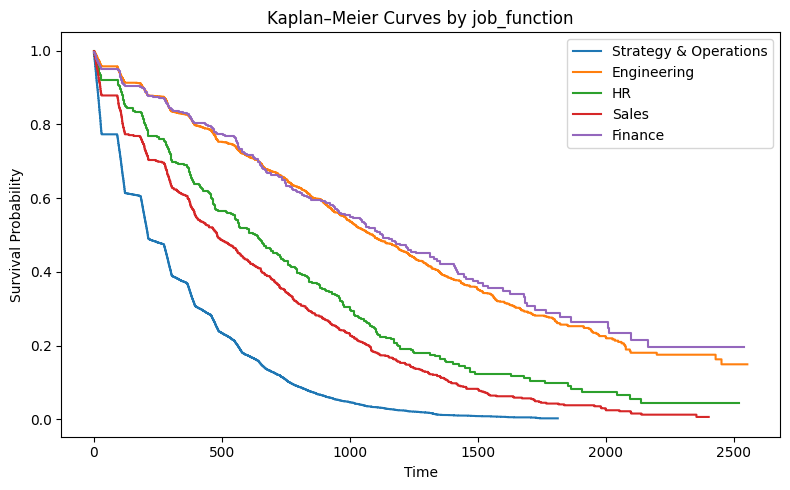


=== Pairwise Log-Rank Test Results ===
                                   test_statistic              p    -log2(p)
Engineering Finance                      0.371542   5.421650e-01    0.883196
            HR                         121.028032   3.767703e-28   91.100301
            Sales                      406.080661   2.613821e-90  297.587368
            Strategy & Operations     3030.121453   0.000000e+00         inf
Finance     HR                          69.441921   7.869808e-17   53.496449
            Sales                      168.523177   1.554989e-38  125.596363
            Strategy & Operations      693.893260  6.363019e-153  505.585287
HR          Sales                       13.718014   2.124073e-04   12.200879
            Strategy & Operations      293.486166   8.649034e-66  216.134715
Sales       Strategy & Operations      332.635419   2.563282e-74  244.464687

Interpretation:
 - Check p-values in the table above. If p < 0.05, those two groups
   have significantly differ

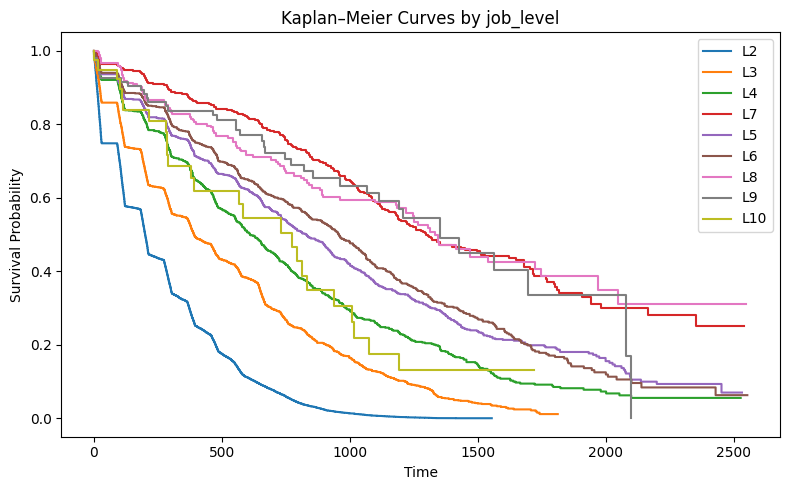


=== Pairwise Log-Rank Test Results ===
        test_statistic              p    -log2(p)
L10 L2       43.302740   4.689264e-11   34.311848
    L3        5.169211   2.299066e-02    5.442808
    L4        0.000005   9.982272e-01    0.002560
    L5        2.348702   1.253874e-01    2.995536
    L6        4.654585   3.097073e-02    5.012951
    L7       25.255838   5.020738e-07   20.925597
    L8       14.104541   1.729258e-04   12.497559
    L9       11.654324   6.405348e-04   10.608435
L2  L3      977.112651  1.695150e-214  710.131199
    L4     1007.422271  4.374592e-221  732.016960
    L5     1678.741897   0.000000e+00         inf
    L6     1472.183979   0.000000e+00         inf
    L7     1447.654663   0.000000e+00         inf
    L8      544.934841  1.591759e-120  397.960750
    L9      233.116197   1.246727e-52  172.422115
L3  L4      119.484142   8.204865e-28   89.977507
    L5      347.755280   1.306061e-77  255.403241
    L6      355.487416   2.705223e-79  260.996572
    L7    

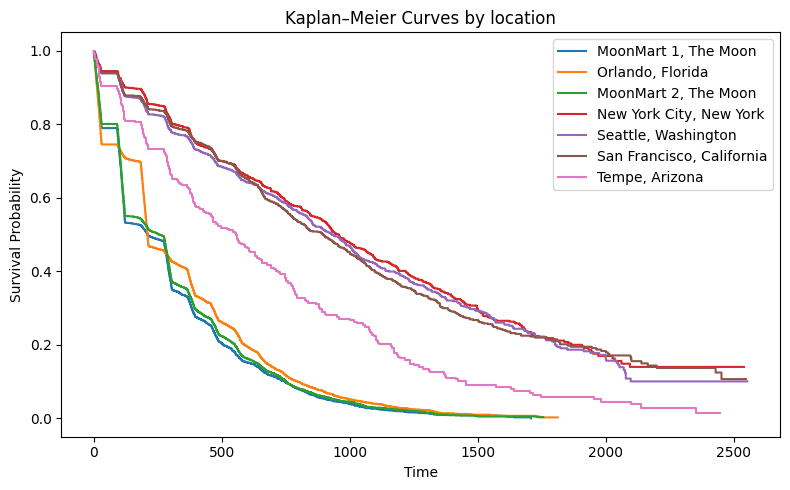


=== Pairwise Log-Rank Test Results ===
                                                     test_statistic  \
MoonMart 1, The Moon      MoonMart 2, The Moon             3.015178   
                          New York City, New York       1268.798571   
                          Orlando, Florida                33.460601   
                          San Francisco, California     1382.154181   
                          Seattle, Washington           1137.678689   
                          Tempe, Arizona                 173.992061   
MoonMart 2, The Moon      New York City, New York       1206.119290   
                          Orlando, Florida                15.243959   
                          San Francisco, California     1309.550055   
                          Seattle, Washington           1079.079905   
                          Tempe, Arizona                 158.317970   
New York City, New York   Orlando, Florida              1163.332769   
                          San Francis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import pairwise_logrank_test

def km_subgroup_analysis(df, time_col='duration', event_col='event', category_col='job_function'):
    """
    Plots Kaplan-Meier curves for multiple subgroups in `category_col`,
    then performs pairwise log-rank tests to compare survival across groups.

    Parameters:
    -----------
    df : pd.DataFrame
        Must contain at least the columns: time_col, event_col, category_col.
    time_col : str
        Name of the column holding the time-to-event values.
    event_col : str
        Name of the column indicating whether the event occurred (1) or censored (0).
    category_col : str
        Categorical column used to stratify the data (e.g., job_function, location, etc.).

    Returns:
    --------
    None (prints log-rank test results and shows a plot)
    """

    # Get unique categories
    categories = df[category_col].dropna().unique()

    # Plot KM curves for each subgroup
    plt.figure(figsize=(8, 5))
    kmf = KaplanMeierFitter()

    for cat in categories:
        subset = df[df[category_col] == cat]
        kmf.fit(
            durations=subset[time_col],
            event_observed=subset[event_col],
            label=str(cat)
        )
        kmf.plot(ci_show=False)

    plt.title(f"Kaplan–Meier Curves by {category_col}")
    plt.xlabel("Time")
    plt.ylabel("Survival Probability")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Pairwise log-rank test across all categories
    # Pass arguments in the correct order: event durations, groups, event observed
    results = pairwise_logrank_test(df[time_col], df[category_col], df[event_col])
    print("\n=== Pairwise Log-Rank Test Results ===")
    print(results.summary)
    print("\nInterpretation:")
    print(" - Check p-values in the table above. If p < 0.05, those two groups")
    print("   have significantly different survival curves.")


km_subgroup_analysis(df_cox, time_col='duration', event_col='event', category_col='job_function')
km_subgroup_analysis(df_cox, time_col='duration', event_col='event', category_col='job_level')
km_subgroup_analysis(df_cox, time_col='duration', event_col='event', category_col='location')

#probabilities output method**** attrition rate in 365. days for diff in department


# Fixed Effects Model

In [ ]:
!pip install linearmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.3 MB/s eta 0:00:00


Employee‐Level Modeling
Logistic Regression or Survival Analysis

Logistic Regression: Model the probability that an employee leaves in a given quarter (binary 1 = termination, 0 = active).
Survival / Cox Model: Treat departure as a “time‐to‐event” problem. This approach accounts for varying tenure, censorship (if still active), etc.
Fixed Effects vs. Mixed Effects

Fixed Effects: Controls for unobserved, time‐invariant individual differences. Ideal if you want to isolate the effects of changing variables (like promotions).
Mixed Effects / Random Effects: Allows both within‐employee variation and between‐employee variation. Potentially more flexible but more complex.

In [ ]:
import pandas as pd
import numpy as np
from linearmodels import PanelOLS, RandomEffects
from linearmodels.panel import compare
import statsmodels.api as sm
import matplotlib.pyplot as plt

#  Checking Variation in job_level_num

variation = df.groupby('employee_id')['job_level_num'].agg(['nunique', 'std']).reset_index()
variation['is_static'] = variation['nunique'] <= 1  # static if only one unique level
static_fraction = variation['is_static'].mean()
print("Fraction of employees with static job_level_num:", static_fraction)


#  Setting Up Panel Data
df_panel = df.set_index(["employee_id", "effective_date"]).sort_index()

#  Creating a Cumulative Promotion Variable
df.sort_values(["employee_id", "effective_date"], inplace=True)
df["promotion_cumulative"] = df.groupby("employee_id")["promotion_flag"].cumsum()
# Re-set the panel index with the updated df
df_panel = df.set_index(["employee_id", "effective_date"]).sort_index()


#  Fitting a Fixed Effects Model (FE)
# FE drops time‑invariant regressors. Here we include promotion_cumulative.
fe_model = PanelOLS.from_formula(
    "turnover_flag ~ 1 + promotion_cumulative + EntityEffects",
    data=df_panel
)
fe_res = fe_model.fit(cov_type="clustered", cluster_entity=True)
print("\n=== Fixed Effects Model ===")
print(fe_res)


# Fitting a Random Effects Model (RE)
re_model = RandomEffects.from_formula(
    "turnover_flag ~ 1 + promotion_cumulative + tenure_days + job_level_num",
    data=df_panel
)
re_res = re_model.fit(cov_type="clustered", cluster_entity=True)
print("\n=== Random Effects Model ===")
print(re_res)

# Fitting a Correlated Random Effects (Mundlak) Model

df_panel = df_panel.copy()
df_panel['job_level_mean'] = df_panel.groupby(level="employee_id")["job_level_num"].transform("mean")

re_mundlak_model = RandomEffects.from_formula(
    "turnover_flag ~ 1 + promotion_cumulative + tenure_days + job_level_num + job_level_mean",
    data=df_panel
)
re_mundlak_res = re_mundlak_model.fit(cov_type="clustered", cluster_entity=True)
print("\n=== Correlated RE (Mundlak) Model ===")
print(re_mundlak_res)

# Fit a Hybrid Model (Between-Within Decomposition)

df_panel['job_level_between'] = df_panel.groupby(level="employee_id")["job_level_num"].transform("mean")
df_panel['job_level_within'] = df_panel["job_level_num"] - df_panel["job_level_between"]


fe_hybrid_model = PanelOLS.from_formula(
    "turnover_flag ~ 1 + tenure_days + job_level_within + EntityEffects",
    data=df_panel,
    drop_absorbed=True
)
fe_hybrid_res = fe_hybrid_model.fit(cov_type="clustered", cluster_entity=True)
print("\n=== Hybrid FE Model (Within Effect of job_level_num) ===")
print(fe_hybrid_res)

# Performing a Manual Hausman Test (for overlapping coefficients)

fe_params = fe_hybrid_res.params[['tenure_days']]
re_params = re_res.params[['tenure_days']]

print("\nFE (Hybrid) 'tenure_days' Coefficient:")
print(fe_params)
print("RE 'tenure_days' Coefficient:")
print(re_params)

# Computing the difference in coefficients:
diff = fe_params - re_params

# Compute the difference in covariance matrices for 'tenure_days':
cov_diff = fe_hybrid_res.cov.loc[['tenure_days'], ['tenure_days']] - re_res.cov.loc[['tenure_days'], ['tenure_days']]

try:
    inv_cov_diff = np.linalg.inv(cov_diff)
    hausman_stat = float(diff.T.dot(inv_cov_diff).dot(diff))
    df_hausman = len(diff)
    # Compute p-value (sm.stats.chisqprob is deprecated; use sm.stats.chisqprob if available or chi2.sf from scipy.stats)
    from scipy.stats import chi2
    p_value = 1 - chi2.cdf(hausman_stat, df=df_hausman)
    print("\nHausman Test Statistic for 'tenure_days':", hausman_stat, "with", df_hausman, "df, p-value:", p_value)
except np.linalg.LinAlgError:
    print("\nCovariance difference matrix is singular; cannot perform Hausman test for 'tenure_days'.")




Fraction of employees with static job_level_num: 0.9434627144115666

=== Fixed Effects Model ===
                          PanelOLS Estimation Summary                           
Dep. Variable:          turnover_flag   R-squared:                        0.0029
Estimator:                   PanelOLS   R-squared (Between):             -0.2785
No. Observations:               69000   R-squared (Within):               0.0029
Date:                Sat, Mar 15 2025   R-squared (Overall):             -0.0172
Time:                        19:59:00   Log-likelihood                -1.719e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      142.87
Entities:                       19297   P-value                           0.0000
Avg Obs:                       3.5757   Distribution:                 F(1,49702)
Min Obs:                       1.0000                                           
Max Obs:    

In [ ]:
pip install lifelines statsmodels


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 5.2 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=1a4926ffd1411ceb6c875cea66f0e9fd58548ca4843d936b1dd02d344bf6fa63
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


Columns in the modeling dataset:
['employee_id', 'effective_date', 'job_function', 'job_level', 'employee_status', 'hire_date', 'role_volume_type', 'tenure_days', 'turnover_flag', 'job_level_num', 'previous_level_num', 'promotion_flag', 'tenure_squared', 'job_level_sq', 'previous_job_function', 'job_function_change_flag', 'previous_pay_rate_type', 'pay_rate_type_change_flag', 'promotion_date', 'last_promotion_date', 'days_since_last_promotion', 'promotion_cumulative', 'duration', 'event', 'pay_rate_type_Salary', 'location_MoonMart 2, The Moon', 'location_New York City, New York', 'location_Orlando, Florida', 'location_San Francisco, California', 'location_Seattle, Washington', 'location_Tempe, Arizona']

Covariates used in the model:
['job_level_num', 'pay_rate_type_change_flag', 'pay_rate_type_Salary', 'location_MoonMart 2, The Moon', 'location_New York City, New York', 'location_Orlando, Florida', 'location_San Francisco, California', 'location_Seattle, Washington', 'location_Tempe, 

<lifelines.CoxPHFitter: fitted with 19297 total observations, 5091 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 19297
number of events observed = 14206
   partial log-likelihood = -121969.76
         time fit was run = 2025-03-15 20:45:40 UTC

---
                                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                           
job_level_num                      -0.20      0.82      0.02           -0.23           -0.17                0.79                0.84
pay_rate_type_change_flag           1.52      4.57      0.02            1.48            1.56                4.40                4.75
pay_rate_type_Salary               -0.34      0.71      0.03           -0.40           -0.29                0.67                0.75
location_MoonMart 2, The Moon      -0.03      0.97      0.02           -0.08            0.02                0.93                1.02
location_New York City, New York   -0.52      0.60      0.06           -0.63           -0.40                0.53                0.67
location_Orlando, Florida          -0.18      0.84      0.02           -0.22           -0.13                0.80                0.88
location_San Francisco, California -0.45      0.64      0.06           -0.56           -0.34                0.57                0.71
location_Seattle, Washington       -0.45      0.64      0.06           -0.56           -0.33                0.57                0.72
location_Tempe, Arizona            -0.00      1.00      0.08           -0.15            0.15                0.86                1.16

                                    cmp to      z      p  -log2(p)
covariate                                                         
job_level_num                         0.00 -12.57 <0.005    117.99
pay_rate_type_change_flag             0.00  77.34 <0.005       inf
pay_rate_type_Salary                  0.00 -11.93 <0.005    106.54
location_MoonMart 2, The Moon         0.00  -1.12   0.26      1.94
location_New York City, New York      0.00  -8.77 <0.005     58.90
location_Orlando, Florida             0.00  -7.84 <0.005     47.66
location_San Francisco, California    0.00  -7.91 <0.005     48.51
location_Seattle, Washington          0.00  -7.44 <0.005     43.20
location_Tempe, Arizona               0.00  -0.02   0.98      0.02
---
Concordance = 0.77
Partial AIC = 243957.53
log-likelihood ratio test = 10377.74 on 9 df
-log2(p) of ll-ratio test = inf

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 19297 total observations, 5091 right-censored observations>
         test_name = proportional_hazard_test

---
                                         test_statistic      p  -log2(p)
job_level_num                      km              0.42   0.52      0.95
                                   rank            0.86   0.35      1.50
location_MoonMart 2, The Moon      km              0.45   0.50      0.99
                                   rank            0.38   0.54      0.90
location_New York City, New York   km              0.13   0.71      0.49
                                   rank            0.51   0.47      1.08
location_Orlando, Florida          km             18.77 <0.005     16.05
                                   rank           18.54 <0.005     15.88
location_San Francisco, California km              0.00   0.99      0.01
                                   rank            0.14   0.71      0.49
location_Seattle, Washington       km              0.04   0.83      0.26
                                   rank            0.02   0.90      0.15
location_Tempe, Arizona            km              2.12   0.15      2.78
                                   rank            3.32   0.07      3.87
pay_rate_type_Salary               km             85.36 <0.005     65.12
                                   rank           90.70 <0.005     69.02
pay_rate_type_change_flag          km           1704.62 <0.005       inf
                                   rank         2018.76 <0.005       inf



1. Variable 'pay_rate_type_change_flag' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['pay_rate_type_change_flag',
...]` in the call in `.fit`. See documentation in link [E] below.

2. Variable 'pay_rate_type_Salary' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['pay_rate_type_Salary',
...]` in the call in `.fit`. See documentation in link [E] below.

3. Variable 'location_Orlando, Florida' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['location_Orlando, Florida',
...]` in the call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-va

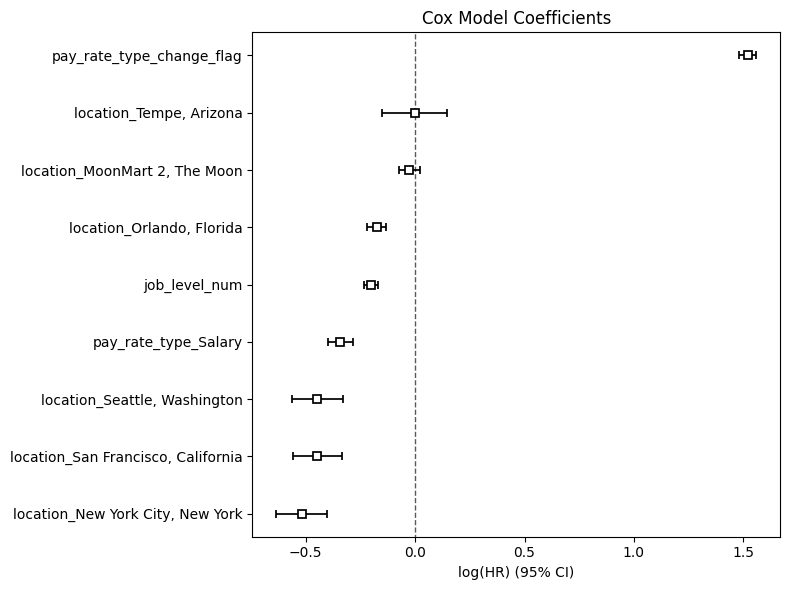

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter


# Prepare the Data

# df_cox is our DataFrame with columns: 'duration', 'event', 'job_level_num', 'pay_rate_type', 'location'
# Creating dummy variables for categorical variables (we are using drop_first to avoid multicollinearity)
df_cox_model = df_cox.copy()
categorical_vars = ['pay_rate_type', 'location']  # add other categorical variables as needed.
df_cox_model = pd.get_dummies(df_cox_model, columns=categorical_vars, drop_first=True)

# Checking the resulting columns
print("Columns in the modeling dataset:")
print(df_cox_model.columns.tolist())

# Define the list of covariates to include
covariates = ['job_level_num'] + [col for col in df_cox_model.columns
                                  if col.startswith('pay_rate_type_') or col.startswith('location_')]
print("\nCovariates used in the model:")
print(covariates)


# Fit the Cox Proportional Hazards Model

cph = CoxPHFitter()
cph.fit(df_cox_model[['duration', 'event'] + covariates], duration_col='duration', event_col='event')

print("\n=== Cox Proportional Hazards Model Summary ===")
cph.print_summary()


#  Validating the Proportional Hazards Assumption

# This function will output test statistics and plots for each covariate.
# A p-value < 0.05 for any test suggests that the proportional hazards assumption may be violated.
cph.check_assumptions(df_cox_model[['duration', 'event'] + covariates], p_value_threshold=0.05)


# Visualizing the Model's Coefficient Estimates

plt.figure(figsize=(8,6))
cph.plot()
plt.title("Cox Model Coefficients")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt

# 1. Filter for Strategy & Operations Employees
strategy_df = df[df['job_function'] == 'Strategy & Operations'].copy()

# 2. Compute Survival Variables
# Converting effective_date and hire_date to datetime
strategy_df['effective_date'] = pd.to_datetime(strategy_df['effective_date'], errors='coerce')
strategy_df['hire_date'] = pd.to_datetime(strategy_df['hire_date'], errors='coerce')

# Creating 'duration' as days from hire_date to effective_date (or last observation)
strategy_df['duration'] = (strategy_df['effective_date'] - strategy_df['hire_date']).dt.days

# Ensuring turnover_flag is 1 for terminated, 0 for active
strategy_df['turnover_flag'] = np.where(strategy_df['employee_status'].str.lower() == 'terminated', 1, 0)

# 3. Collapse Panel Data to One Row per Employee (Last Observation)
strategy_sorted = strategy_df.sort_values(["employee_id", "effective_date"])
strategy_last = strategy_sorted.groupby("employee_id").last().reset_index()

# 4. Create/Encode Predictors
# Encode pay_rate_type: e.g., 1 for Hourly, 0 for Salary
strategy_last['pay_rate_type_enc'] = strategy_last['pay_rate_type'].map({'Hourly': 1, 'Salary': 0})

# Create a binary indicator for low job level ( Entry level if job_level_num <= 4)
# Adjust threshold as needed
strategy_last['low_job_level'] = np.where(strategy_last['job_level_num'] <= 4, 1, 0)

# create an interaction variable: Hourly * low job level
strategy_last['interaction'] = strategy_last['pay_rate_type_enc'] * strategy_last['low_job_level']

# 5.Fit the Cox Proportional Hazards Model
# Drop any rows with missing values in key columns
strategy_surv = strategy_last.dropna(subset=['duration','turnover_flag','pay_rate_type_enc','job_level_num','low_job_level'])

cph = CoxPHFitter()
# You can include the interaction term if you want to test if the combination of being hourly and at a low level is especially risky.
cph.fit(strategy_surv[['duration','turnover_flag','pay_rate_type_enc','job_level_num','low_job_level','interaction']],
        duration_col='duration', event_col='turnover_flag')
print("\n=== Cox Proportional Hazards Model for Strategy & Operations ===")
cph.print_summary()

# 6. Validate the Proportional Hazards Assumption
# This will output diagnostic tests and plots.
cph.check_assumptions(strategy_surv[['duration','turnover_flag','pay_rate_type_enc','job_level_num','low_job_level','interaction']], p_value_threshold=0.05, show_plots=True)




ModuleNotFoundError: No module named 'lifelines'

# TimeSeries

In [ ]:
!pip install linearmodels


<ipython-input-52-13ef49309651>:17: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  ts_terminations = ts_terminations.asfreq('Q').fillna(0)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfoa2lnta/mm6km0ek.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfoa2lnta/jd9xinij.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53024', 'data', 'file=/tmp/tmpfoa2lnta/mm6km0ek.json', 'init=/tmp/tmpfoa2lnta/jd9xinij.json', 'output', 'file=/tmp/tmpfoa2lnta/prophet_modelw8k4o_0j/prophet_model-20250315210343.csv', 'method=optimize', 'a

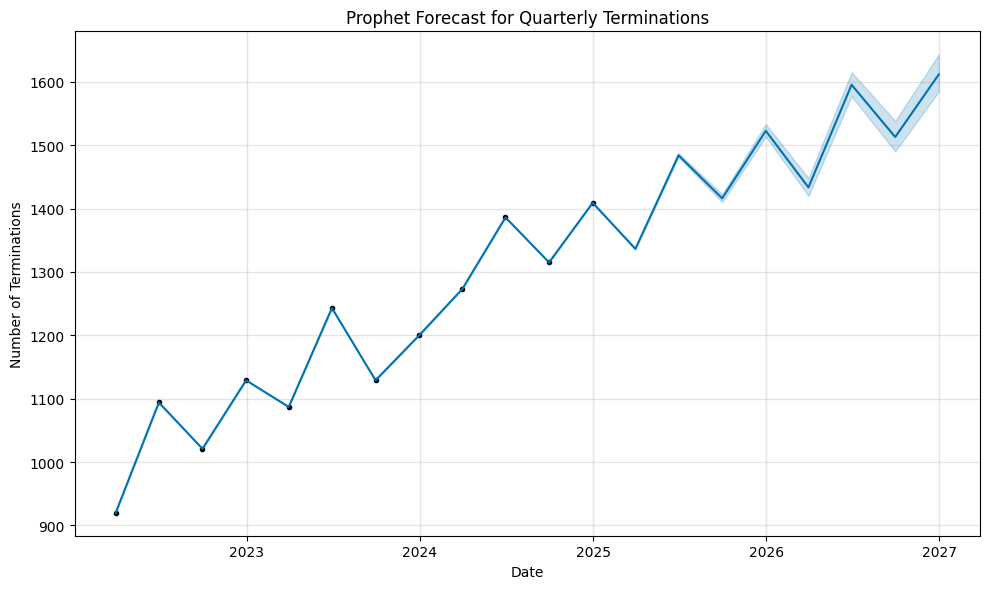

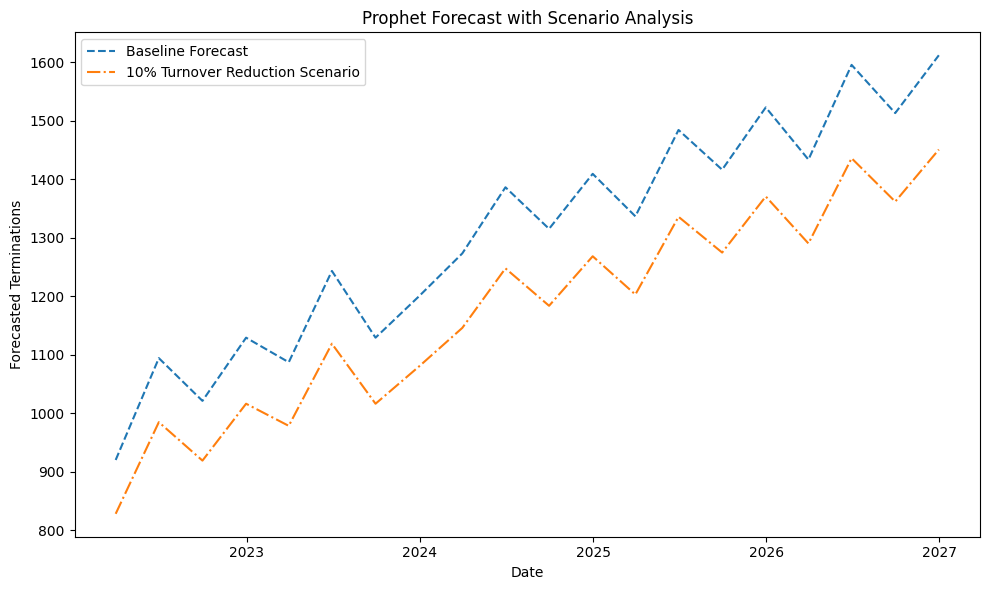

In [ ]:
# FORECASTING TURNOVER USING PROPHET


import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# Aggregating quarterly terminations
# Filter for terminated employees and group by effective_date
ts_terminations = df[df['employee_status'].str.lower() == 'terminated'] \
                    .groupby('effective_date')['employee_id'].nunique()

# Ensure the series has quarterly frequency. If not, reindex:
ts_terminations = ts_terminations.asfreq('Q').fillna(0)

# Prepare DataFrame for Prophet: Prophet requires columns 'ds' (datetime) and 'y' (value)
df_prophet = ts_terminations.reset_index()
df_prophet.columns = ['ds', 'y']

# Fit Prophet model
model_prophet = Prophet()
model_prophet.fit(df_prophet)

# Forecast future terminations: e.g., next 8 quarters (2 years)
future = model_prophet.make_future_dataframe(periods=8, freq='Q')
forecast = model_prophet.predict(future)

# Plot the forecast
fig1 = model_prophet.plot(forecast)
plt.title("Prophet Forecast for Quarterly Terminations")
plt.xlabel("Date")
plt.ylabel("Number of Terminations")
plt.tight_layout()
plt.show()

# Scenario Analysis Example:
# Suppose a targeted program is expected to reduce turnover by 10%.
forecast['yhat_scenario'] = forecast['yhat'] * 0.90

plt.figure(figsize=(10,6))
plt.plot(forecast['ds'], forecast['yhat'], label="Baseline Forecast", linestyle="--")
plt.plot(forecast['ds'], forecast['yhat_scenario'], label="10% Turnover Reduction Scenario", linestyle="-.")
plt.title("Prophet Forecast with Scenario Analysis")
plt.xlabel("Date")
plt.ylabel("Forecasted Terminations")
plt.legend()
plt.tight_layout()
plt.show()


# Appendix

In [ ]:
# For encoding categorical variables
from sklearn.preprocessing import LabelEncoder

# For logistic regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

cat_cols = ['location','pay_rate_type','role_volume_type']
for col in cat_cols:
    encoder = LabelEncoder()
    df[col+'_enc'] = encoder.fit_transform(df[col].astype(str))

# Dropping rows if they do not have enough data (like negative tenure or weird missing)
df_model = df.dropna(subset=['tenure_days'])

# Our target is turnover_flag
X = df_model[['tenure_days', 'job_level_num', 'rehire_flag', 'promotion_flag',
              'location_enc', 'pay_rate_type_enc', 'role_volume_type_enc']]
y = df_model['turnover_flag']

# Split into training & test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train logistic regression
logreg = LogisticRegression(max_iter=1000)  # increase max_iter if data is large
logreg.fit(X_train, y_train)

# Evaluate model
y_pred = logreg.predict(X_test)
print("\n--- LOGISTIC REGRESSION EVALUATION ---\n")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))



--- LOGISTIC REGRESSION EVALUATION ---

Confusion Matrix:
 [[10959     0]
 [ 2841     0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      1.00      0.89     10959
           1       0.00      0.00      0.00      2841

    accuracy                           0.79     13800
   macro avg       0.40      0.50      0.44     13800
weighted avg       0.63      0.79      0.70     13800



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Extract the numeric portion from job_level (e.g., L5 -> 5)
df['job_level_numeric'] = df['job_level'].str.extract('(\d+)').astype(int)

Fixed effect model - apply that, check for multicollinearity, crosstabs

Department wise look at how many employees are there

<Axes: xlabel='job_function', ylabel='count'>

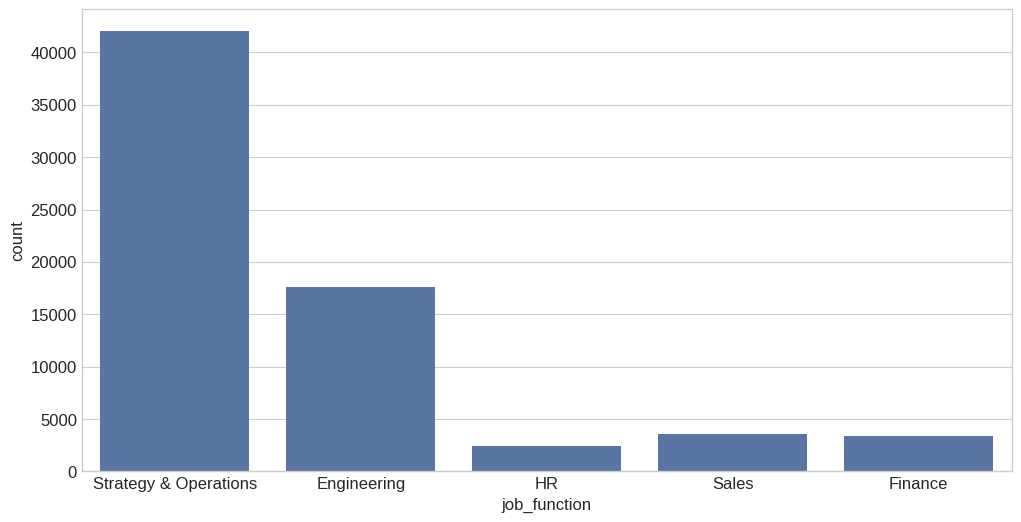

In [ ]:
#Most employees are from the Strategy & Operations, Engineering function
sns.countplot(x = 'job_function', data = df)

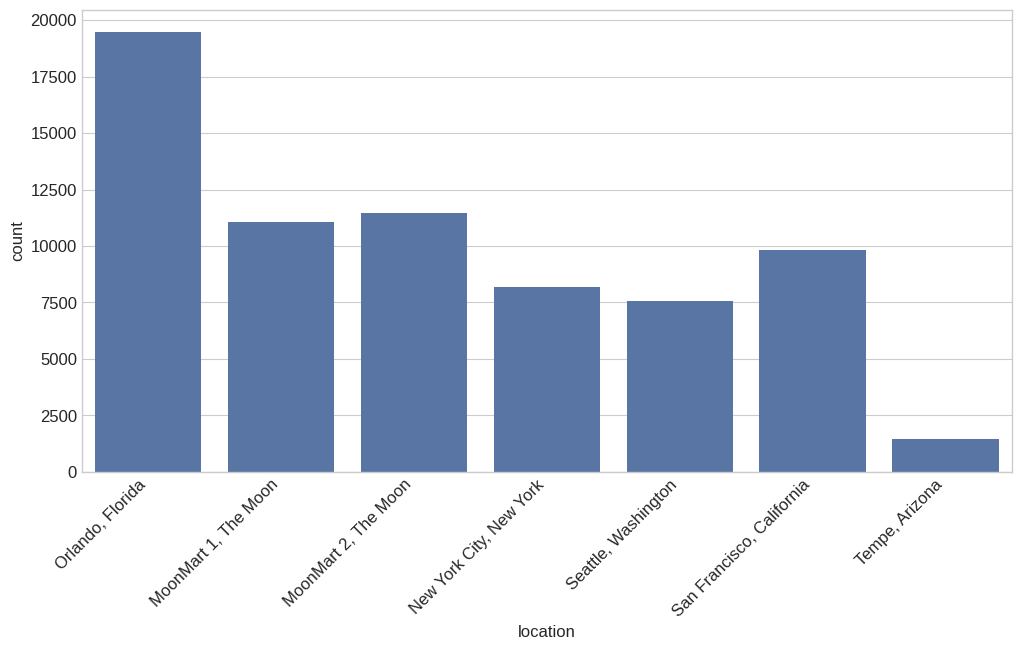

In [ ]:
#Most popular cities where employees are from is Orlando, Florida

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))  # Increase figure size for better spacing
sns.countplot(x='location', data=df)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

<Axes: xlabel='job_level', ylabel='count'>

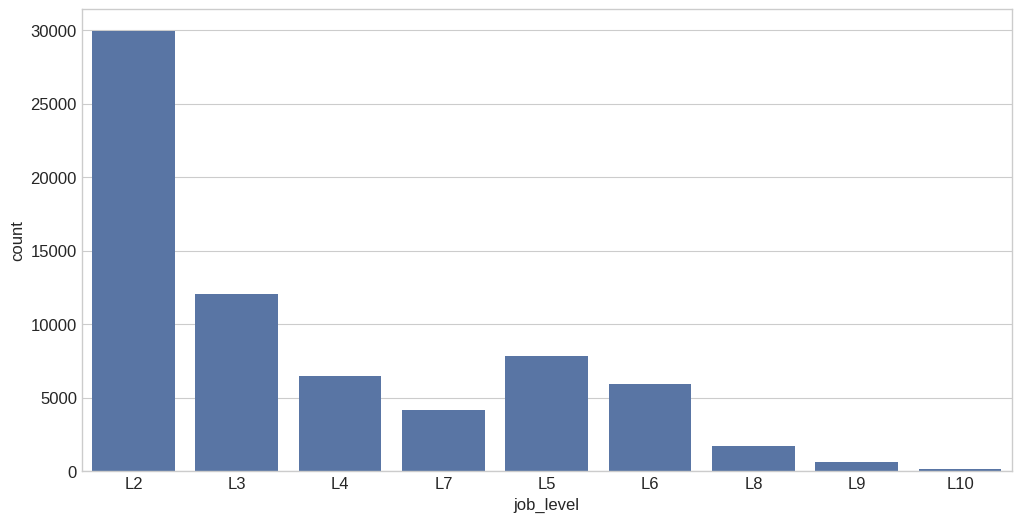

In [ ]:
#L2 and L3 levels have the highest number of employees meanwhile L10 and L9 has the lowest
sns.countplot(x = 'job_level', data = df)

#Rejoin if there or not? tenure prediction? **No of active employees at a time

<Axes: xlabel='employee_status', ylabel='count'>

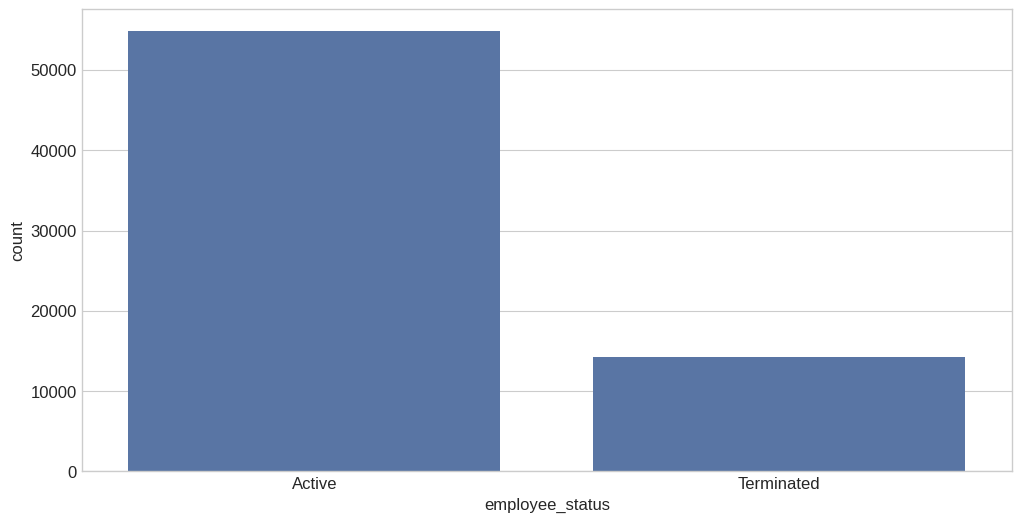

In [ ]:
sns.countplot(x = 'employee_status', data = df)

<Axes: xlabel='pay_rate_type', ylabel='count'>

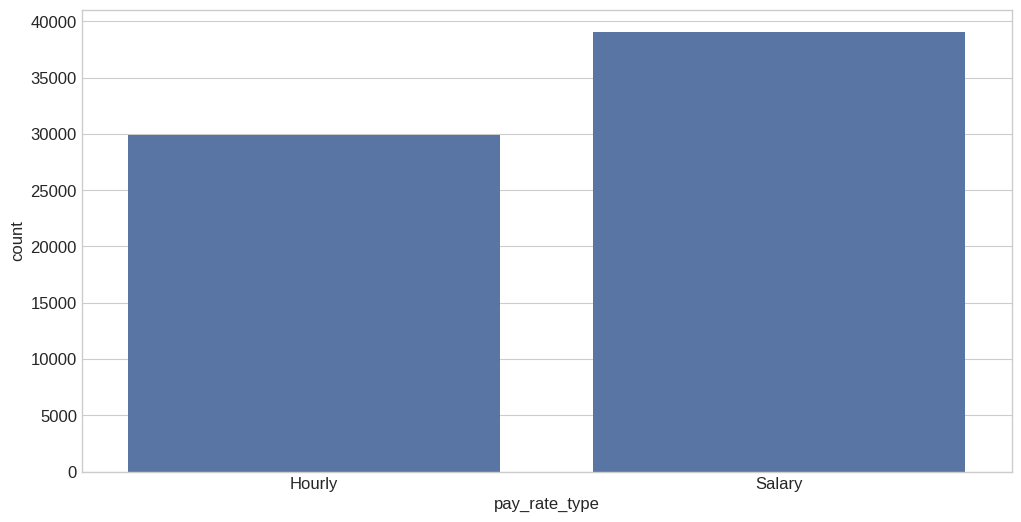

In [ ]:
sns.countplot(x = 'pay_rate_type', data = df)

<Axes: xlabel='role_volume_type', ylabel='count'>

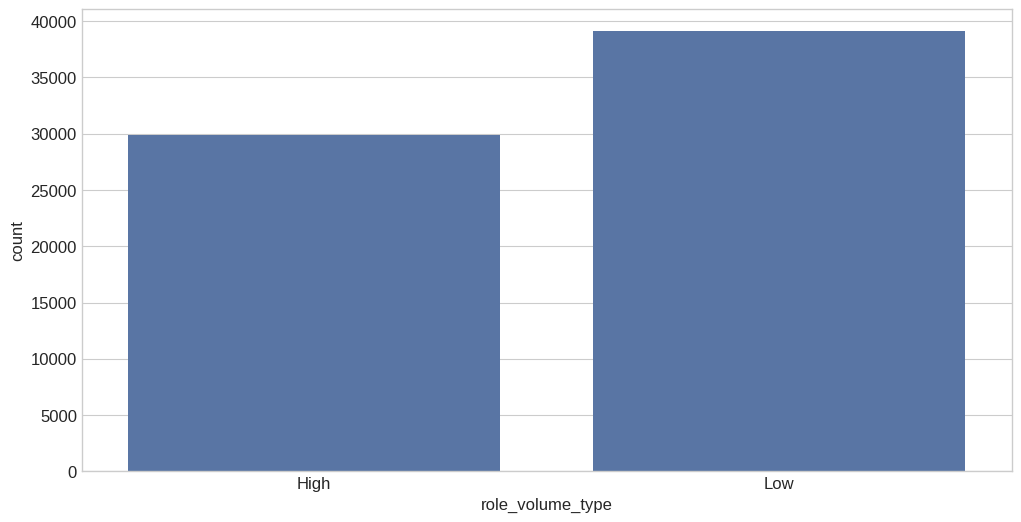

In [ ]:
sns.countplot(x = 'role_volume_type', data = df)

In [ ]:
#Calculate tenure with the company in months
df['tenure_months'] = ((df['effective_date'] - df['hire_date']).dt.days / 30).round().astype(int)
df.head()

,effective_date,employee_id,job_function,location,job_level,employee_status,hire_date,pay_rate_type,role_volume_type,is_last_record,is_terminated,tenure_months
28381,2022-03-31,1,Strategy & Operations,"Orlando, Florida",L2,Active,2020-01-26,Hourly,High,False,False,26
31349,2022-06-30,1,Strategy & Operations,"MoonMart 1, The Moon",L2,Terminated,2020-01-26,Hourly,High,True,True,30
27805,2022-03-31,2,Strategy & Operations,"Orlando, Florida",L2,Terminated,2021-05-06,Hourly,High,True,True,11
29341,2022-03-31,3,Strategy & Operations,"MoonMart 1, The Moon",L2,Active,2020-05-22,Hourly,High,False,False,23
32332,2022-06-30,3,Strategy & Operations,"MoonMart 1, The Moon",L2,Terminated,2020-05-22,Hourly,High,True,True,26


Univariate Analysis

In [ ]:
# Distribution of employees by location# Distribution of employees by location
location_counts = df.groupby('location')['employee_id'].nunique()
print("\nEmployee Distribution by Location:")
print(location_counts)

# Distribution by job function
function_counts = df.groupby('job_function')['employee_id'].nunique()
print("\nEmployee Distribution by Job Function:")
print(function_counts)

# Distribution by job level
level_counts = df.groupby('job_level')['employee_id'].nunique()
print("\nEmployee Distribution by Job Level:")
print(level_counts)



Employee Distribution by Location:
location
MoonMart 1, The Moon         5498
MoonMart 2, The Moon         5526
New York City, New York      1410
Orlando, Florida             8394
San Francisco, California    1705
Seattle, Washington          1344
Tempe, Arizona                346
Name: employee_id, dtype: int64

Employee Distribution by Job Function:
job_function
Engineering               2849
Finance                    543
HR                         496
Sales                      917
Strategy & Operations    14492
Name: employee_id, dtype: int64

Employee Distribution by Job Level:
job_level
L10       39
L2     11620
L3      3274
L4      1497
L5      1696
L6      1259
L7       657
L8       250
L9        96
Name: employee_id, dtype: int64


Looking at Turnover

In [ ]:
df['Terminated'] = df['employee_status'].apply(lambda x: 1 if x == 'Terminated' else 0)
df.head()

,effective_date,employee_id,job_function,location,job_level,employee_status,hire_date,pay_rate_type,role_volume_type,is_last_record,is_terminated,tenure_months,Terminated
28381,2022-03-31,1,Strategy & Operations,"Orlando, Florida",L2,Active,2020-01-26,Hourly,High,False,False,26,0
31349,2022-06-30,1,Strategy & Operations,"MoonMart 1, The Moon",L2,Terminated,2020-01-26,Hourly,High,True,True,30,1
27805,2022-03-31,2,Strategy & Operations,"Orlando, Florida",L2,Terminated,2021-05-06,Hourly,High,True,True,11,1
29341,2022-03-31,3,Strategy & Operations,"MoonMart 1, The Moon",L2,Active,2020-05-22,Hourly,High,False,False,23,0
32332,2022-06-30,3,Strategy & Operations,"MoonMart 1, The Moon",L2,Terminated,2020-05-22,Hourly,High,True,True,26,1


In [ ]:
# Extract year-month from effective_date for monthly analysis
df['year_month'] = df['effective_date'].dt.to_period('M').astype(str)

In [ ]:
# 1. Create a quarterly period column from effective_date
df['year_quarter'] = df['effective_date'].dt.to_period('Q')

Bivariate Analysis

In [ ]:
import pandas as pd

# Create a dictionary to store the results for each bivariate analysis
results = {}

# Group by job_function to count total employees and sum terminations
turnover_by_function = df.groupby('job_function').agg(
    total_employees=('employee_id', 'count'),
    terminations=('Terminated', 'sum')
)
# Calculate the turnover rate as a percentage
turnover_by_function['turnover_rate'] = (
    turnover_by_function['terminations'] / turnover_by_function['total_employees'] * 100
)
# Sort by turnover rate in descending order so the highest rates come first
results['turnover_by_function'] = turnover_by_function.sort_values(
    'turnover_rate', ascending=False
)
print("Turnover by Job Function:")
print(results['turnover_by_function'])

# Group by location to calculate total employees and terminations
turnover_by_location = df.groupby('location').agg(
    total_employees=('employee_id', 'count'),
    terminations=('Terminated', 'sum')
)
# Compute the turnover rate
turnover_by_location['turnover_rate'] = (
    turnover_by_location['terminations'] / turnover_by_location['total_employees'] * 100
)
# Sort locations by turnover rate (highest first)
results['turnover_by_location'] = turnover_by_location.sort_values(
    'turnover_rate', ascending=False
)
print("\nTurnover by Location:")
print(results['turnover_by_location'])


# Group by job_level to determine counts and terminations
turnover_by_level = df.groupby('job_level').agg(
    total_employees=('employee_id', 'count'),
    terminations=('Terminated', 'sum')
)
# Calculate turnover rate
turnover_by_level['turnover_rate'] = (
    turnover_by_level['terminations'] / turnover_by_level['total_employees'] * 100
)
# Sort by job level (assumes that lower levels come first)
results['turnover_by_level'] = turnover_by_level.sort_index()
print("\nTurnover by Job Level:")
print(results['turnover_by_level'])


# Group by pay_rate_type to examine the impact of pay type on turnover
turnover_by_pay = df.groupby('pay_rate_type').agg(
    total_employees=('employee_id', 'count'),
    terminations=('Terminated', 'sum')
)
# Calculate the percentage turnover rate
turnover_by_pay['turnover_rate'] = (
    turnover_by_pay['terminations'] / turnover_by_pay['total_employees'] * 100
)
# Sort by turnover rate in descending order
results['turnover_by_pay'] = turnover_by_pay.sort_values(
    'turnover_rate', ascending=False
)
print("\nTurnover by Pay Rate Type:")
print(results['turnover_by_pay'])


# Group by role_volume_type to see if high-volume roles differ in turnover rates
turnover_by_volume = df.groupby('role_volume_type').agg(
    total_employees=('employee_id', 'count'),
    terminations=('Terminated', 'sum')
)
# Compute turnover rate
turnover_by_volume['turnover_rate'] = (
    turnover_by_volume['terminations'] / turnover_by_volume['total_employees'] * 100
)
# Sort results so that the highest turnover rates appear first
results['turnover_by_volume'] = turnover_by_volume.sort_values(
    'turnover_rate', ascending=False
)
print("\nTurnover by Role Volume Type:")
print(results['turnover_by_volume'])

# Create tenure bins for better understanding of turnover over employee tenure
tenure_bins = [0, 3, 6, 12, 24, 36, float('inf')]
tenure_labels = ['0-3 months', '3-6 months', '6-12 months', '1-2 years', '2-3 years', '3+ years']
df['tenure_group'] = pd.cut(df['tenure_months'], bins=tenure_bins, labels=tenure_labels, right=False)

# Group by the new tenure_group column and calculate totals and terminations
turnover_by_tenure = df.groupby('tenure_group').agg(
    total_employees=('employee_id', 'count'),
    terminations=('Terminated', 'sum')
)
# Calculate the turnover rate for each tenure group
turnover_by_tenure['turnover_rate'] = (
    turnover_by_tenure['terminations'] / turnover_by_tenure['total_employees'] * 100
)
# Preserve the original bin order by sorting by the index (tenure_group)
results['turnover_by_tenure'] = turnover_by_tenure.sort_index()
print("\nTurnover by Tenure:")
print(results['turnover_by_tenure'])

print("\nBivariate turnover analysis completed.")


Turnover by Job Function:
                       total_employees  terminations  turnover_rate
job_function                                                       
Strategy & Operations            42000         11592      27.600000
Sales                             3572           741      20.744681
HR                                2384           338      14.177852
Engineering                      17634          1297       7.355109
Finance                           3410           238       6.979472

Turnover by Location:
                           total_employees  terminations  turnover_rate
location                                                               
MoonMart 1, The Moon                 11071          3334      30.114714
MoonMart 2, The Moon                 11452          3315      28.946909
Orlando, Florida                     19477          4943      25.378652
Tempe, Arizona                        1461           263      18.001369
Seattle, Washington                   7548 

<ipython-input-27-0c411966c31e>:108: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  turnover_by_tenure = df.groupby('tenure_group').agg(


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

# Feature engineering for predictive modeling
def engineer_features(df):
    """
    Engineer features for predictive modeling
    """
    print("Engineering features for prediction...")

    # Create a copy of the dataframe for feature engineering
    model_df = df.copy()

    # Convert categorical variables to one-hot encoding
    categorical_cols = ['job_function', 'location', 'job_level', 'pay_rate_type', 'role_volume_type']

    # One-hot encode categorical features
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoded_features = encoder.fit_transform(model_df[categorical_cols])

    # Get feature names after one-hot encoding
    feature_names = []
    for i, col in enumerate(categorical_cols):
        categories = encoder.categories_[i][1:]  # Drop the first category (reference)
        for category in categories:
            feature_names.append(f"{col}_{category}")

    # Create a DataFrame with encoded features
    encoded_df = pd.DataFrame(encoded_features, columns=feature_names)

    # Combine with numerical features
    numerical_cols = ['tenure_months']

    # Combine all features into a single DataFrame
    X = pd.concat([model_df[numerical_cols].reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)
    y = model_df['Terminated']

    print(f"Feature engineering completed. Number of features: {X.shape[1]}")
    return X, y

In [ ]:
# Build predictive model for turnover
def build_turnover_model(X, y):
    """
    Build a predictive model for employee turnover
    """
    print("Building predictive model for turnover...")

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train a Random Forest Classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    print("\nModel Evaluation:")
    print(classification_report(y_test, y_pred))

    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nTop 10 Important Features:")
    print(feature_importance.head(10))

    return model, feature_importance

In [ ]:
# Engineer features for predictive modeling
X, y = engineer_features(df)

# Build predictive model
model, feature_importance = build_turnover_model(X, y)

Engineering features for prediction...
Feature engineering completed. Number of features: 21
Building predictive model for turnover...

Model Evaluation:
              precision    recall  f1-score   support

           0       0.79      0.99      0.88     10934
           1       0.31      0.02      0.03      2866

    accuracy                           0.79     13800
   macro avg       0.55      0.50      0.46     13800
weighted avg       0.69      0.79      0.70     13800


Top 10 Important Features:
                               Feature  Importance
0                        tenure_months    0.540893
19                pay_rate_type_Salary    0.080120
20                role_volume_type_Low    0.078208
11                        job_level_L2    0.071846
4   job_function_Strategy & Operations    0.068544
3                   job_function_Sales    0.029272
8   location_San Francisco, California    0.016514
12                        job_level_L3    0.016090
6     location_New York City, Ne